EN4.2.2 abyssal ocean trends compared to model

In [19]:
# Load modules
%pylab inline
from netCDF4 import Dataset # to work with NetCDF files
import numpy as np
import matplotlib.pyplot as plt # to generate plots

from os.path import expanduser
home = expanduser("~") # Get users home directory
import os # operating system interface
import scipy as sp
import xarray as xr
import scipy.interpolate
import scipy.ndimage
#import seawater as sw
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean.cm as cmocean
from dask.distributed import Client
import cartopy.feature as cfeature

import cartopy.crs as ccrs
import cmocean.cm as cmocean
import matplotlib.path as mpath
import matplotlib.gridspec as gridspec


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [20]:
client = Client(n_workers=8)
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38419 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:44409' processes=8 threads=8, memory=100.00 GiB>

In [21]:
#calculate linear trends
#https://gist.github.com/rabernat/bc4c6990eb20942246ce967e6c9c3dbe
# define a function to compute a linear trend of a timeseries
#tmp=tmp.polyfit(dim='time',deg=1,skipna=False,full=True)

def linear_trend(x):
    yrs=np.arange(0,x.time.shape[0],1)
    pf = np.polyfit(yrs, x, 1,full=True)
    # we need to return a dataarray or else xarray's groupby won't be happy
    return xr.DataArray(pf[0])

In [22]:
#calculate volume transport in rho space across -61S and between -54W to -32W 
#or northward volume transport across 60S between 60W to 20W, between 1000-4000m and 4-6km depth 

lat_slice  = slice(-84,-20)

#monthly data ... super slow to resample ... or fails completely
#of = '/g/data/jk72/pas561/jnb/EN422/EN.4.2.2.f.analysis.c14.*.nc'
#print(of)
#en4=xr.open_mfdataset(of,engine='netcdf4',combine='nested',concat_dim='time').sel(lat=lat_slice).temperature - 273.15 #.resample({'time':'Y'}).mean('time')
#en4


of = '/g/data/jk72/pas561/jnb/EN422/annual_mean.EN.4.2.2.f.analysis.c14.nc'
print(of)
en4=xr.open_dataset(of).sel(lat=lat_slice).temperature - 273.15 #.resample({'time':'Y'}).mean('time')
en4


/g/data/jk72/pas561/jnb/EN422/annual_mean.EN.4.2.2.f.analysis.c14.nc


<xarray.DataArray 'temperature' (time: 52, depth: 42, lat: 64, lon: 360)>
array([[[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [20.61394389, 20.34985813, 20.27630599, ..., 21.44356505,
          21.17996804, 20.89152559],
         [20.74015347, 20.45484622, 20.3785526 , ..., 21.54969994,
          21.28802665, 21.00718069],
         [20.847809  , 20.52300819, 20.42516144, ..., 21.62637138,
          21.37350527, 21.10755396]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
...
         [ 1.97677556,  1.97410052,  1.97106321, ...,  1.98824073,
           1.97625695,  1.97490885],
         [ 1.97612379,  1.97578005,  1.97257287, ...,  1.98602827,
           1.97212882,  1.97110378],
         [ 1.97391554,  1.97339382,  1.9709986 , ...,  1.98412246,
           1.97074204,  1.97028771]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [ 1.91936823,  1.91917744,  1.9189378 , ...,         nan,
           1.91881127,  1.91855766],
         [ 1.91976107,  1.91951966,  1.91881347, ...,         nan,
           1.91775879,  1.91746695],
         [ 1.91943871,  1.91915497,  1.91801997, ...,         nan,
           1.9180675 ,  1.91782295]]]])
Coordinates:
  * depth    (depth) float32 5.022 15.08 25.16 ... 4.752e+03 5.051e+03 5.35e+03
  * lat      (lat) float32 -83.0 -82.0 -81.0 -80.0 ... -23.0 -22.0 -21.0 -20.0
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0
  * time     (time) datetime64[ns] 1970-07-01T16:58:07.500000256 ... 2021-07-...

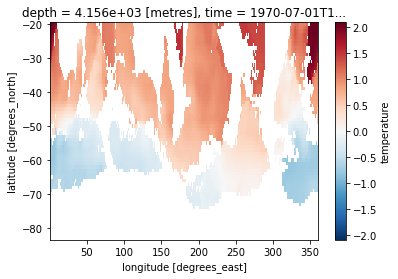

In [23]:
en4[0,37,:,:].plot()

In [24]:
en4.depth[36:]

<xarray.DataArray 'depth' (depth: 6)>
array([3858.6763, 4155.628 , 4453.502 , 4752.021 , 5050.9897, 5350.272 ],
      dtype=float32)
Coordinates:
  * depth    (depth) float32 3.859e+03 4.156e+03 ... 5.051e+03 5.35e+03
Attributes:
    long_name:      depth
    units:          metres
    positive:       down
    standard_name:  depth
    bounds:         depth_bnds

In [25]:
#create depth weigths
en4_dzt=np.diff(en4.depth)
en4_dzt=np.insert(en4_dzt,0,en4.depth[0])

en4_dzt_xr = xr.DataArray(en4_dzt, 
coords={'depth': en4.depth,}, 
dims=["depth"])
en4_dzt_xr.name = "dzt"
en4_dzt_xr

<xarray.DataArray 'dzt' (depth: 42)>
array([  5.0215898,  10.05695  ,  10.08192  ,  10.11783  ,  10.169472 ,
        10.243732 ,  10.350491 ,  10.503929 ,  10.724373 ,  11.040894 ,
        11.494995 ,  12.145721 ,  13.076653 ,  14.405182 ,  16.294724 ,
        18.96901  ,  22.727982 ,  27.960724 ,  35.14795  ,  44.839966 ,
        57.59137  ,  73.83548  ,  93.70126  , 116.82074  , 142.22668  ,
       168.44623  , 193.81006  , 216.8551   , 236.62952  , 252.78015  ,
       265.4464   , 275.0664   , 282.19678  , 287.38574  , 291.11206  ,
       293.7627   , 295.6355   , 296.95166  , 297.87402  , 298.51904  ,
       298.96875  , 299.28223  ], dtype=float32)
Coordinates:
  * depth    (depth) float32 5.022 15.08 25.16 ... 4.752e+03 5.051e+03 5.35e+03

In [26]:
#depth_slice=slice(4000,6000)
depth_slice = slice(4000,None)

In [27]:
#tmp=en4.sel(time=slice('1979-01-01','1988-12-31')).sel(depth=depth_slice).mean(dim='time')

#calc 1979-1988 mean depth average
EN4_4km=(en4.sel(depth=depth_slice)*en4_dzt_xr[37:]).sum(dim='depth')/ en4_dzt_xr[37:].values.sum()
EN4_4km.load()

<xarray.DataArray (time: 52, lat: 64, lon: 360)>
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [1.99309421, 1.99013433, 1.96989425, ..., 1.61051487,
         1.99282959, 1.99258997],
        [1.99131697, 1.99072331, 1.98272981, ..., 1.60842475,
         1.9895985 , 1.98944529],
        [1.9874919 , 1.98825444, 1.98726574, ..., 1.60523475,
         1.98650907, 1.98624701]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
...
        [1.99632774, 1.99366649, 1.9729425 , ..., 1.6136168 ,
         1.99592859, 1.9956359 ],
        [1.99418307, 1.99370246, 1.98522322, ..., 1.61135868,
         1.99247946, 1.99220329],
        [1.99002676, 1.99067601, 1.98927074, ..., 1.60805357,
         1.98921679, 1.98879634]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [1.99743934, 1.99285235, 1.97209529, ..., 1.61757658,
         1.99896182, 1.99770133],
        [1.99546667, 1.99315486, 1.98463604, ..., 1.61538144,
         1.99560772, 1.99439324],
        [1.99148523, 1.99041922, 1.98893546, ..., 1.61217558,
         1.99243733, 1.99110961]]])
Coordinates:
  * lat      (lat) float32 -83.0 -82.0 -81.0 -80.0 ... -23.0 -22.0 -21.0 -20.0
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0
  * time     (time) datetime64[ns] 1970-07-01T16:58:07.500000256 ... 2021-07-...

In [28]:
#tmp=en4.sel(time=slice('2009-01-01','2018-12-31')).sel(depth=depth_slice).mean(dim='time')

#calc 1979-1988 mean depth average
#abyssal_t_EN4_late=(tmp*en4_dzt_xr[37:]).sum(dim='depth')/ en4_dzt_xr[37:].values.sum()

abyssal_t_EN4_early=EN4_4km.sel(time=slice('1979-01-01','1988-12-31')).mean(dim='time')
abyssal_t_EN4_late=EN4_4km.sel(time=slice('2009-01-01','2018-12-31')).mean(dim='time')


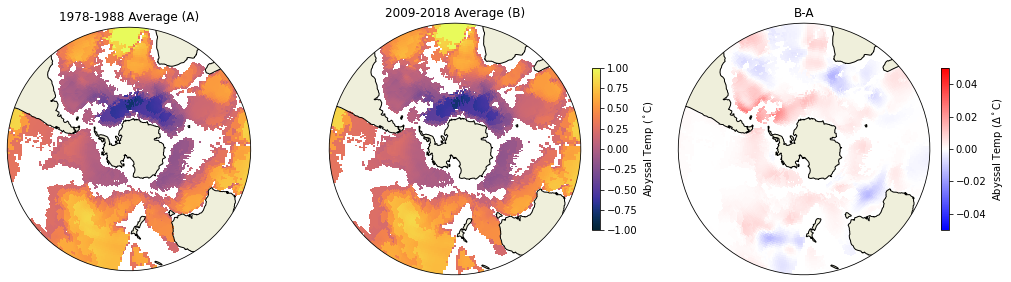

In [29]:
fig  = plt.figure(1, figsize = (22.5*0.75, 7.5*0.75))
gs = gridspec.GridSpec(1,3, width_ratios = [0.9,1,1])
gs.update(wspace = 0.3, hspace=0)

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax1, ax2, ax3 = plt.subplot(gs[0,0], projection=ccrs.SouthPolarStereo()), \
           plt.subplot(gs[0,1], projection=ccrs.SouthPolarStereo()), \
           plt.subplot(gs[0,2], projection=ccrs.SouthPolarStereo())

im1 = abyssal_t_EN4_early.where(abyssal_t_EN4_early!=0).plot.pcolormesh(ax=ax1, transform=ccrs.PlateCarree(), vmin=-1, vmax=1, cmap=cmocean.thermal, add_colorbar=False)
#ax1.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[4000],colors='k',linewidths=0.5, transform = ccrs.PlateCarree())
ax1.coastlines()
ax1.set_title('1978-1988 Average (A)')
ax1.add_feature(cfeature.LAND)
ax1.set_boundary(circle, transform=ax1.transAxes)

im1 = abyssal_t_EN4_late.where(abyssal_t_EN4_late!=0).plot.pcolormesh(ax=ax2, transform=ccrs.PlateCarree(), vmin=-1, vmax=1, cmap=cmocean.thermal, add_colorbar=False)
#ax2.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[4000],colors='k',linewidths=0.5, transform = ccrs.PlateCarree())
ax2.coastlines()
ax2.set_title('2009-2018 Average (B)')
ax2.add_feature(cfeature.LAND)
ax2.set_boundary(circle, transform=ax2.transAxes)

im3 = (abyssal_t_EN4_late-abyssal_t_EN4_early).where((abyssal_t_EN4_late-abyssal_t_EN4_early)!=0).plot.pcolormesh(ax=ax3, transform=ccrs.PlateCarree(), vmin=-0.05, vmax=0.05, cmap=plt.cm.bwr, add_colorbar=False)
#ax3.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[4000],colors='k',linewidths=0.5, transform = ccrs.PlateCarree())
ax3.coastlines()
ax3.set_title('B-A')
ax3.add_feature(cfeature.LAND)
ax3.set_boundary(circle, transform=ax3.transAxes)

cb1 = plt.colorbar(im1, ax=ax2, fraction=0.03, pad=0.04)
cb2 = plt.colorbar(im3, ax=ax3, fraction=0.03, pad=0.04)

cb1.set_label('Abyssal Temp ($^\circ$C)')
cb2.set_label('Abyssal Temp ($\Delta^\circ$C)')

# plt.savefig(figdir+'Abyssal_temp.png', bbox_inches='tight', dpi=300)
plt.show()

In [20]:
trend_2000s_4km

<xarray.DataArray (dim_0: 2, lat: 64, lon: 360)>
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 2.01554884e-03,  3.40754014e-03,  3.51565165e-03, ...,
          9.55011215e-05,  9.59856143e-04,  1.46976908e-03],
        [ 1.03631595e-03,  2.23135589e-03,  2.38359049e-03, ...,
         -4.06541428e-04,  2.96760061e-04,  6.54731278e-04],
        [ 4.91507578e-04,  1.47923065e-03,  1.65854798e-03, ...,
         -6.20412485e-04, -3.00339145e-05,  2.04508129e-04]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 1.99211966e+01,  1.98746199e+01,  1.96669993e+01, ...,
          1.61051970e+01,  1.99264770e+01,  1.99206855e+01],
        [ 1.99050374e+01,  1.98843420e+01,  1.97996433e+01, ...,
          1.60849080e+01,  1.98946075e+01,  1.98900625e+01],
        [ 1.98681234e+01,  1.98627235e+01,  1.98486059e+01, ...,
          1.60536994e+01,  1.98643372e+01,  1.98590914e+01]]])
Coordinates:
  * lat      (lat) float64 -83.0 -82.0 -81.0 -80.0 ... -23.0 -22.0 -21.0 -20.0
  * lon      (lon) float64 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0
Dimensions without coordinates: dim_0

In [21]:
#depth_slice=slice(4000,6000)
depth_slice = slice(1000,4000)
en4.depth[25:37]

<xarray.DataArray 'depth' (depth: 12)>
array([ 967.99585, 1161.8059 , 1378.661  , 1615.2905 , 1868.0707 , 2133.517  ,
       2408.5835 , 2690.7803 , 2978.166  , 3269.278  , 3563.0408 , 3858.6763 ],
      dtype=float32)
Coordinates:
  * depth    (depth) float32 968.0 1.162e+03 1.379e+03 ... 3.563e+03 3.859e+03
Attributes:
    long_name:      depth
    units:          metres
    positive:       down
    standard_name:  depth
    bounds:         depth_bnds

In [22]:
en4_dzt_xr[26:37]

<xarray.DataArray 'dzt' (depth: 11)>
array([193.81006, 216.8551 , 236.62952, 252.78015, 265.4464 , 275.0664 ,
       282.19678, 287.38574, 291.11206, 293.7627 , 295.6355 ],
      dtype=float32)
Coordinates:
  * depth    (depth) float32 1.162e+03 1.379e+03 ... 3.563e+03 3.859e+03

In [23]:
en4.sel(depth=depth_slice)

<xarray.DataArray 'temperature' (time: 52, depth: 11, lat: 64, lon: 360)>
array([[[[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [3.44848653, 3.44547927, 3.44460263, ..., 3.45868518,
          3.45280423, 3.44887912],
         [3.50915106, 3.50667697, 3.50502906, ..., 3.51631109,
          3.51057849, 3.50800178],
         [3.5625449 , 3.56002363, 3.55774812, ..., 3.56896408,
          3.56336602, 3.56105779]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
...
         [2.09658794, 2.0891643 , 2.07277224, ..., 2.10290595,
          2.10173593, 2.09947763],
         [2.10532955, 2.10043631, 2.09172112, ..., 2.11380994,
          2.11183737, 2.10886208],
         [2.11202588, 2.10863872, 2.10304213, ..., 2.12177406,
          2.11909268, 2.115475  ]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [2.06789396, 2.06616642, 2.04426879, ..., 2.07098774,
          2.0699964 , 2.0686183 ],
         [2.0673522 , 2.06455755, 2.05349187, ..., 2.07432181,
          2.07235064, 2.06992793],
         [2.06439791, 2.06155346, 2.05702623, ..., 2.07359044,
          2.07072999, 2.06752805]]]])
Coordinates:
  * depth    (depth) float32 1.162e+03 1.379e+03 ... 3.563e+03 3.859e+03
  * lat      (lat) float32 -83.0 -82.0 -81.0 -80.0 ... -23.0 -22.0 -21.0 -20.0
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0
  * time     (time) datetime64[ns] 1970-07-01T16:58:07.500000256 ... 2021-07-...

In [24]:
#tmp=en4.sel(time=slice('1979-01-01','1988-12-31')).sel(depth=depth_slice).mean(dim='time')

#calc 1979-1988 mean depth average
EN4_1km=(en4.sel(depth=depth_slice)*en4_dzt_xr[26:37]).sum(dim='depth')/ en4_dzt_xr[37:].values.sum()
EN4_1km.load()

<xarray.DataArray (time: 52, lat: 64, lon: 360)>
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [5.03326387, 5.0292531 , 5.02260709, ..., 5.04889759,
         5.04397839, 5.03770794],
        [5.09699648, 5.09312747, 5.08962047, ..., 5.11212109,
         5.10756571, 5.10173726],
        [5.16523079, 5.16077613, 5.1570971 , ..., 5.18084684,
         5.17623304, 5.17032169]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
...
        [5.11823964, 5.12850402, 5.12514101, ..., 5.09831409,
         5.10863254, 5.11461805],
        [5.17761579, 5.18649908, 5.18504256, ..., 5.15866365,
         5.1683371 , 5.17428999],
        [5.24355509, 5.24762385, 5.24414069, ..., 5.22941125,
         5.23713529, 5.24152724]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [5.15428629, 5.14464184, 5.13332622, ..., 5.1461013 ,
         5.15496794, 5.15664601],
        [5.2139289 , 5.2025183 , 5.19253517, ..., 5.20489632,
         5.21413497, 5.21631133],
        [5.27453403, 5.26136   , 5.25078642, ..., 5.269522  ,
         5.27701332, 5.27786586]]])
Coordinates:
  * lat      (lat) float32 -83.0 -82.0 -81.0 -80.0 ... -23.0 -22.0 -21.0 -20.0
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0
  * time     (time) datetime64[ns] 1970-07-01T16:58:07.500000256 ... 2021-07-...

In [25]:
#depth average
tmp=EN4_1km.sel(time=slice('1973-01-01','1980-12-31'))

#the trend method below isway too slow ... why????
#calculate linear trends
#https://gist.github.com/rabernat/bc4c6990eb20942246ce967e6c9c3dbe
# define a function to compute a linear trend of a timeseries
#tmp=tmp.polyfit(dim='time',deg=1,skipna=False,full=True)

#https://gist.github.com/rabernat/bc4c6990eb20942246ce967e6c9c3dbe
# stack lat and lon into a single dimension called allpoints
stacked = tmp.stack(allpoints=['lat','lon'])
# apply the function over allpoints to calculate the trend at each point
trend = stacked.groupby('allpoints').apply(linear_trend)
# unstack back to lat lon coordinates
trend_unstacked = trend.unstack('allpoints')*10

trend_1970s_1km=trend_unstacked.load()

In [26]:
#depth average
tmp=EN4_1km.sel(time=slice('1981-01-01','1990-12-31'))

#the trend method below isway too slow ... why????
#calculate linear trends
#https://gist.github.com/rabernat/bc4c6990eb20942246ce967e6c9c3dbe
# define a function to compute a linear trend of a timeseries
#tmp=tmp.polyfit(dim='time',deg=1,skipna=False,full=True)

#https://gist.github.com/rabernat/bc4c6990eb20942246ce967e6c9c3dbe
# stack lat and lon into a single dimension called allpoints
stacked = tmp.stack(allpoints=['lat','lon'])
# apply the function over allpoints to calculate the trend at each point
trend = stacked.groupby('allpoints').apply(linear_trend)
# unstack back to lat lon coordinates
trend_unstacked = trend.unstack('allpoints')*10

trend_1980s_1km=trend_unstacked.load()

In [27]:
tmp=EN4_1km.sel(time=slice('1991-01-01','2000-12-31'))

# stack lat and lon into a single dimension called allpoints
stacked = tmp.stack(allpoints=['lat','lon'])
# apply the function over allpoints to calculate the trend at each point
trend = stacked.groupby('allpoints').apply(linear_trend)
# unstack back to lat lon coordinates
trend_unstacked = trend.unstack('allpoints')*10

trend_1990s_1km=trend_unstacked.load()

In [28]:
tmp=EN4_1km.sel(time=slice('2001-01-01','2015-12-31'))

# stack lat and lon into a single dimension called allpoints
stacked = tmp.stack(allpoints=['lat','lon'])
# apply the function over allpoints to calculate the trend at each point
trend = stacked.groupby('allpoints').apply(linear_trend)
# unstack back to lat lon coordinates
trend_unstacked = trend.unstack('allpoints')*10

trend_2000s_1km=trend_unstacked.load()

In [29]:
tmp=EN4_1km.sel(time=slice('1980-01-01','2015-12-31'))

# stack lat and lon into a single dimension called allpoints
stacked = tmp.stack(allpoints=['lat','lon'])
# apply the function over allpoints to calculate the trend at each point
trend = stacked.groupby('allpoints').apply(linear_trend)
# unstack back to lat lon coordinates
trend_unstacked = trend.unstack('allpoints')*10

trend_80to15_1km=trend_unstacked.load()

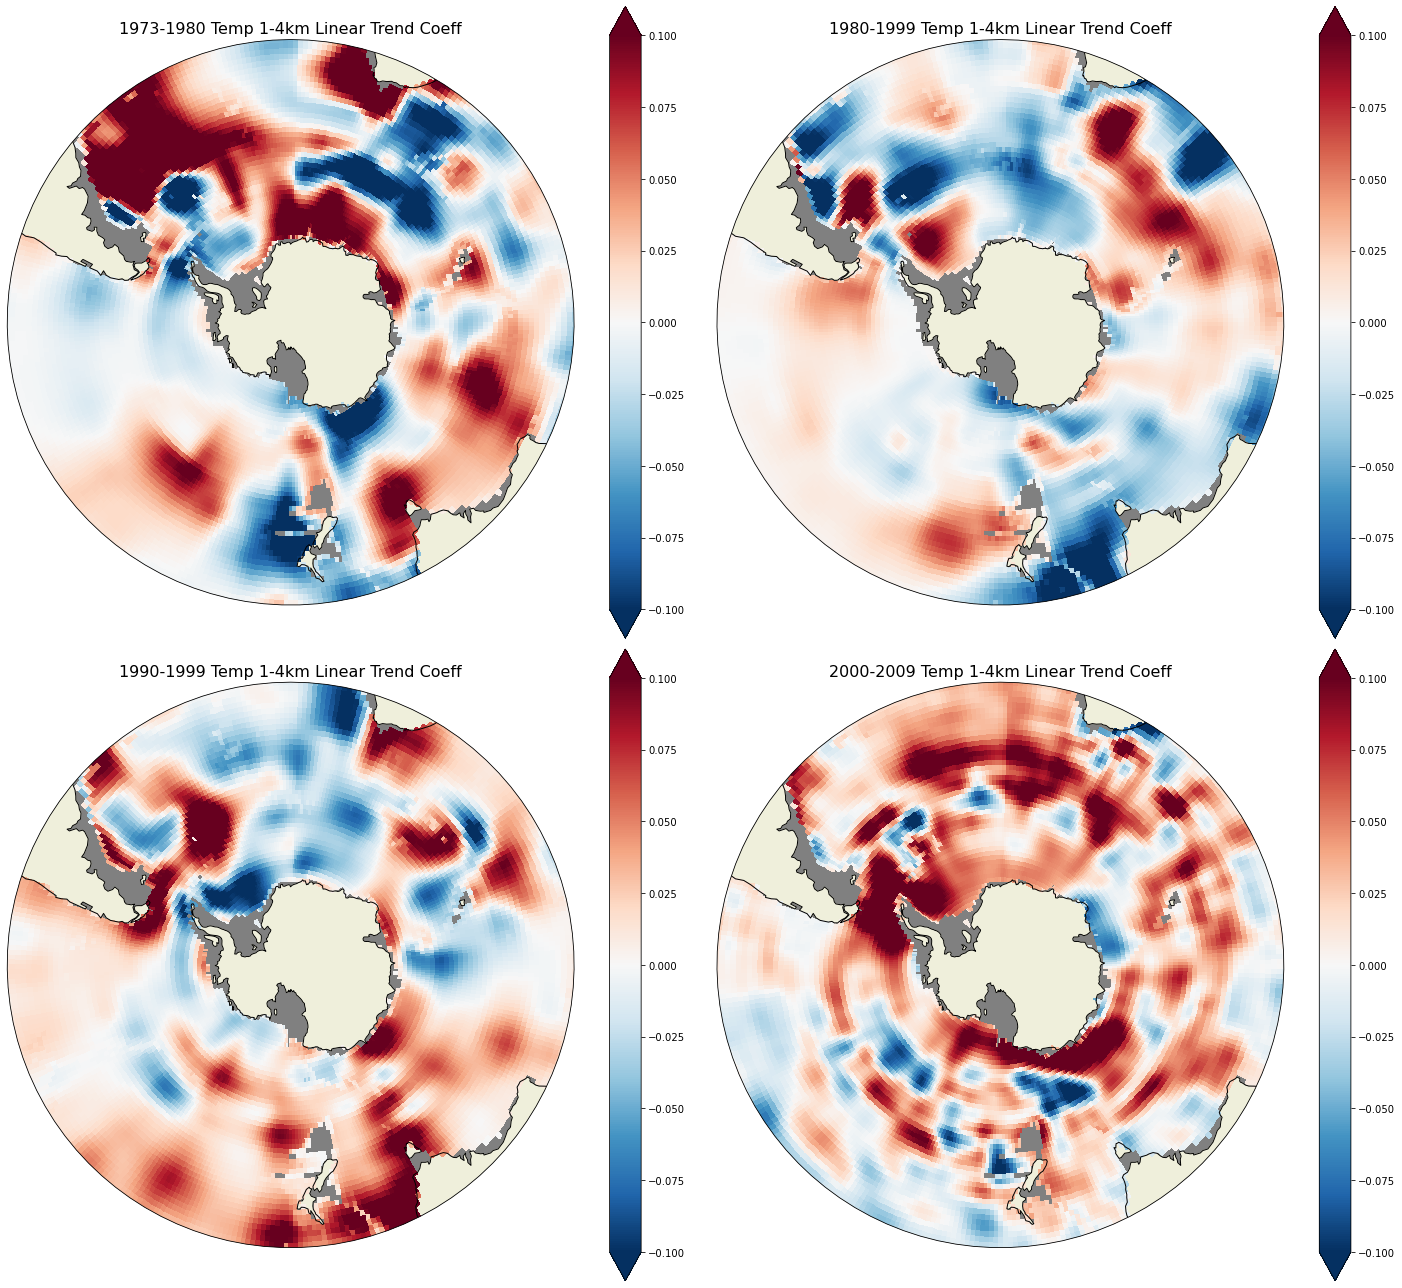

In [30]:
clev = np.arange(-.5,.55,.05)
clev = np.arange(-.2,.22,.02)

v1=-.1
v2=.1

fig = plt.figure(figsize=(20, 18))
    
projection=ccrs.SouthPolarStereo()

ax = plt.subplot(2,2,1, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([0, 360, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

p1 = trend_1970s_1km[0].where(trend_1970s_1km[0]!=0).plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p1 = trend_1970s_4km[0].where(trend_1970s_4km[0]!=0).plot.contourf(x='lon', y='lat', add_colorbar=True,cmap=cmocean.balance, levels=clev, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='1973-1980 Temp 1-4km Linear Trend Coeff'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)

ax = plt.subplot(2,2,2, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([0, 360, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#p1 = tmp.polyfit_coefficients[0].plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
p1 = trend_1980s_1km[0].where(trend_1980s_1km[0]!=0).plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2,extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='1980-1999 Temp 1-4km Linear Trend Coeff'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)

ax = plt.subplot(2,2,3, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([0, 360, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#p1 = tmp.polyfit_coefficients[0].plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
p1 = trend_1990s_1km[0].where(trend_1990s_1km[0]!=0).plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2,extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='1990-1999 Temp 1-4km Linear Trend Coeff'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)

ax = plt.subplot(2,2,4, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([0, 360, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

#p1 = tmp.polyfit_coefficients[0].plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
p1 = trend_2000s_1km[0].where(trend_2000s_1km[0]!=0).plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2,extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='2000-2009 Temp 1-4km Linear Trend Coeff'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)

plt.tight_layout()

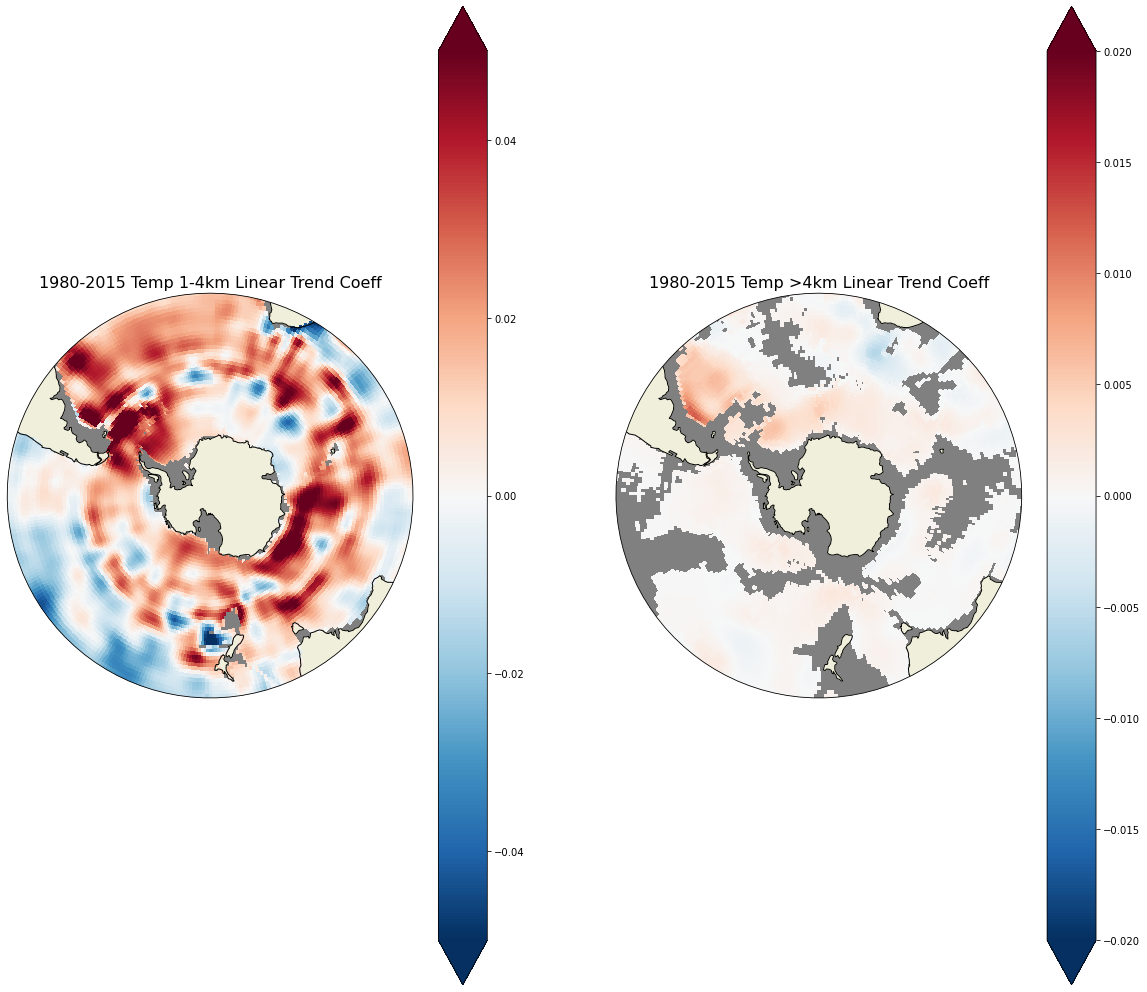

In [32]:
clev = np.arange(-.5,.55,.05)
clev = np.arange(-.2,.22,.02)


fig = plt.figure(figsize=(20, 18))
    
projection=ccrs.SouthPolarStereo()

ax = plt.subplot(1,2,1, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([0, 360, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

v1=-.05
v2=.05
p1 = trend_80to15_1km[0].where(trend_80to15_1km[0]!=0).plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p1 = trend_1970s_4km[0].where(trend_1970s_4km[0]!=0).plot.contourf(x='lon', y='lat', add_colorbar=True,cmap=cmocean.balance, levels=clev, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='1980-2015 Temp 1-4km Linear Trend Coeff'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)

ax = plt.subplot(1,2,2, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([0, 360, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

v1=-.02
v2=.02
#p1 = tmp.polyfit_coefficients[0].plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
p1 = trend_80to15_4km[0].where(trend_80to15_4km[0]!=0).plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2,extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='1980-2015 Temp >4km Linear Trend Coeff'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)


In [33]:
#compare to models
NYFCntrlDir = '/g/data/v45/pas561/mom/archive/wombat_jun16z/'
#this has 3 years of a wind perturbation - get a nice 3 year polynya.
NYFPertDir = '/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/'

of=os.path.join(NYFCntrlDir,'cT_0to1.npy')
np_cT_0to1=np.load(of)

of=os.path.join(NYFCntrlDir,'cT_1to4.npy')
np_cT_1to4=np.load(of)

of=os.path.join(NYFCntrlDir,'cT_2to4.npy')
np_cT_2to4=np.load(of)

of=os.path.join(NYFCntrlDir,'cT_4to6.npy')
np_cT_4to6=np.load(of)  

print(np_cT_0to1.shape)
print(np_cT_1to4.shape)
print(np_cT_4to6.shape)

of=os.path.join(NYFPertDir,'pT_0to1.npy')
np_pT_0to1=np.load(of)

of=os.path.join(NYFPertDir,'pT_1to4.npy')
np_pT_1to4=np.load(of)

of=os.path.join(NYFPertDir,'pT_2to4.npy')
np_pT_2to4=np.load(of)

of=os.path.join(NYFPertDir,'pT_4to6.npy')
np_pT_4to6=np.load(of)  

print(np_pT_0to1.shape)
print(np_pT_1to4.shape)
print(np_pT_4to6.shape)

(49, 1080, 1440)
(49, 1080, 1440)
(49, 1080, 1440)
(44, 1080, 1440)
(44, 1080, 1440)
(44, 1080, 1440)


In [34]:
np.arange(1981,2000,1)

array([1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999])

In [35]:
#calc dT/dt
cyrs=np.arange(1971,2017,1)
pyrs=np.arange(1973,2017,1)

#calc linear trend in C/s since 1981-2000 (8 years from 1973) 
#calc linear trend in C/s since 1981-2000 (8 years from 1973) 
print(cyrs[10:45],cyrs[10:45].shape)
print(pyrs[8:43],pyrs[8:43].shape)

print(cyrs[10:29],cyrs[10:29].shape)
print(pyrs[8:27],pyrs[8:27].shape)

print(cyrs[29:45],cyrs[29:45].shape)
print(pyrs[27:43],pyrs[27:43].shape)


[1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994
 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014 2015] (35,)
[1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994
 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014 2015] (35,)
[1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994
 1995 1996 1997 1998 1999] (19,)
[1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994
 1995 1996 1997 1998 1999] (19,)
[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015] (16,)
[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015] (16,)


In [72]:
np_tr81to15_Tanom_0to1_m=np.zeros((500,1440))
np_tr81to15_Tanom_0to1_p=np.zeros((500,1440))

np_tr81to15_Tanom_1to4_m=np.zeros((500,1440))
np_tr81to15_Tanom_1to4_p=np.zeros((500,1440))

np_tr81to15_Tanom_4to6_m=np.zeros((500,1440))
np_tr81to15_Tanom_4to6_p=np.zeros((500,1440))

np_tr73to80_Tanom_0to1_m=np.zeros((500,1440))
np_tr73to80_Tanom_0to1_p=np.zeros((500,1440))

np_tr73to80_Tanom_1to4_m=np.zeros((500,1440))
np_tr73to80_Tanom_1to4_p=np.zeros((500,1440))

np_tr73to80_Tanom_4to6_m=np.zeros((500,1440))
np_tr73to80_Tanom_4to6_p=np.zeros((500,1440))

np_tr81to00_Tanom_0to1_m=np.zeros((500,1440))
np_tr81to00_Tanom_0to1_p=np.zeros((500,1440))

np_tr81to00_Tanom_1to4_m=np.zeros((500,1440))
np_tr81to00_Tanom_1to4_p=np.zeros((500,1440))

np_tr81to00_Tanom_4to6_m=np.zeros((500,1440))
np_tr81to00_Tanom_4to6_p=np.zeros((500,1440))

np_tr01to15_Tanom_0to1_m=np.zeros((500,1440))
np_tr01to15_Tanom_0to1_p=np.zeros((500,1440))

np_tr01to15_Tanom_1to4_m=np.zeros((500,1440))
np_tr01to15_Tanom_1to4_p=np.zeros((500,1440))

np_tr01to15_Tanom_4to6_m=np.zeros((500,1440))
np_tr01to15_Tanom_4to6_p=np.zeros((500,1440))

anom_0to1=np_pT_0to1[0:43,:,:]-np_cT_0to1[2:45,:,:]
anom_1to4=np_pT_1to4[0:43,:,:]-np_cT_1to4[2:45,:,:]
anom_4to6=np_pT_4to6[0:43,:,:]-np_cT_4to6[2:45,:,:]

for j in range(0,500):
    #print(j)
    
    for i in range(0,1440):
        
        tmp=sp.stats.linregress(range(35), anom_0to1[8:43,j,i])
        np_tr81to15_Tanom_0to1_m[j,i]=tmp.slope
        np_tr81to15_Tanom_0to1_p[j,i]=tmp.pvalue

        tmp=sp.stats.linregress(range(35), anom_1to4[8:43,j,i])
        np_tr81to15_Tanom_1to4_m[j,i]=tmp.slope
        np_tr81to15_Tanom_1to4_p[j,i]=tmp.pvalue

        tmp=sp.stats.linregress(range(35), anom_4to6[8:43,j,i])
        np_tr81to15_Tanom_4to6_m[j,i]=tmp.slope
        np_tr81to15_Tanom_4to6_p[j,i]=tmp.pvalue

        
        tmp=sp.stats.linregress(range(8), anom_0to1[0:8,j,i])
        np_tr73to80_Tanom_0to1_m[j,i]=tmp.slope
        np_tr73to80_Tanom_0to1_p[j,i]=tmp.pvalue

        tmp=sp.stats.linregress(range(8), anom_1to4[0:8,j,i])
        np_tr73to80_Tanom_1to4_m[j,i]=tmp.slope
        np_tr73to80_Tanom_1to4_p[j,i]=tmp.pvalue

        tmp=sp.stats.linregress(range(8), anom_4to6[0:8,j,i])
        np_tr73to80_Tanom_4to6_m[j,i]=tmp.slope
        np_tr73to80_Tanom_4to6_p[j,i]=tmp.pvalue
        
        
        tmp=sp.stats.linregress(range(20), anom_0to1[8:28,j,i])
        np_tr81to00_Tanom_0to1_m[j,i]=tmp.slope
        np_tr81to00_Tanom_0to1_p[j,i]=tmp.pvalue

        tmp=sp.stats.linregress(range(20), anom_1to4[8:28,j,i])
        np_tr81to00_Tanom_1to4_m[j,i]=tmp.slope
        np_tr81to00_Tanom_1to4_p[j,i]=tmp.pvalue

        tmp=sp.stats.linregress(range(20), anom_4to6[8:28,j,i])
        np_tr81to00_Tanom_4to6_m[j,i]=tmp.slope
        np_tr81to00_Tanom_4to6_p[j,i]=tmp.pvalue

        
        tmp=sp.stats.linregress(range(15), anom_0to1[28:43,j,i])
        np_tr01to15_Tanom_0to1_m[j,i]=tmp.slope
        np_tr01to15_Tanom_0to1_p[j,i]=tmp.pvalue

        tmp=sp.stats.linregress(range(15), anom_1to4[28:43,j,i])
        np_tr01to15_Tanom_1to4_m[j,i]=tmp.slope
        np_tr01to15_Tanom_1to4_p[j,i]=tmp.pvalue

        tmp=sp.stats.linregress(range(15), anom_4to6[28:43,j,i])
        np_tr01to15_Tanom_4to6_m[j,i]=tmp.slope
        np_tr01to15_Tanom_4to6_p[j,i]=tmp.pvalue
        

In [73]:
vgrid_file ='/g/data/hh5/tmp/pas561/gfdl_nyf_1080/ocean.ncra501-520.nc'

nc = Dataset(vgrid_file, mode='r') # file handle, open in read only mode
yt_ocean = nc.variables['yt_ocean'][0:500]
xt_ocean = nc.variables['xt_ocean'][:]
nc.close() # close the file
#print st_ocean.shape
#print potrho.shape
#print yt_ocean.shape

In [74]:
#0-1km
tmp = xr.DataArray(np_tr81to15_Tanom_0to1_m, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr81to15_Tanom_0to1_m.nc')

tmp = xr.DataArray(np_tr81to15_Tanom_0to1_p, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr81to15_Tanom_0to1_p.nc')

#1-4km
tmp = xr.DataArray(np_tr81to15_Tanom_1to4_m, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr81to15_Tanom_1to4_m.nc')

tmp = xr.DataArray(np_tr81to15_Tanom_1to4_p, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr81to15_Tanom_1to4_p.nc')

#4-6km
tmp = xr.DataArray(np_tr81to15_Tanom_4to6_m, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr81to15_Tanom_4to6_m.nc')

tmp = xr.DataArray(np_tr81to15_Tanom_4to6_p, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr81to15_Tanom_4to6_p.nc')

In [75]:
#0-1km
tmp = xr.DataArray(np_tr73to80_Tanom_0to1_m, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr73to80_Tanom_0to1_m.nc')

tmp = xr.DataArray(np_tr73to80_Tanom_0to1_p, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr73to80_Tanom_0to1_p.nc')

#1-4km
tmp = xr.DataArray(np_tr73to80_Tanom_1to4_m, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr73to80_Tanom_1to4_m.nc')

tmp = xr.DataArray(np_tr73to80_Tanom_1to4_p, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr73to80_Tanom_1to4_p.nc')

#4-6km
tmp = xr.DataArray(np_tr73to80_Tanom_4to6_m, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr73to80_Tanom_4to6_m.nc')

tmp = xr.DataArray(np_tr73to80_Tanom_4to6_p, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr73to80_Tanom_4to6_p.nc')

In [76]:
#0-1km
tmp = xr.DataArray(np_tr81to00_Tanom_0to1_m, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr81to00_Tanom_0to1_m.nc')

tmp = xr.DataArray(np_tr81to00_Tanom_0to1_p, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr81to00_Tanom_0to1_p.nc')

#1-4km
tmp = xr.DataArray(np_tr81to00_Tanom_1to4_m, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr81to00_Tanom_1to4_m.nc')

tmp = xr.DataArray(np_tr81to00_Tanom_1to4_p, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr81to00_Tanom_1to4_p.nc')

#4-6km
tmp = xr.DataArray(np_tr81to00_Tanom_4to6_m, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr81to00_Tanom_4to6_m.nc')

tmp = xr.DataArray(np_tr81to00_Tanom_4to6_p, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr81to00_Tanom_4to6_p.nc')

In [77]:
#0-1km
tmp = xr.DataArray(np_tr01to15_Tanom_0to1_m, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr01to15_Tanom_0to1_m.nc')

tmp = xr.DataArray(np_tr01to15_Tanom_0to1_p, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr01to15_Tanom_0to1_p.nc')

#1-4km
tmp = xr.DataArray(np_tr01to15_Tanom_1to4_m, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr01to15_Tanom_1to4_m.nc')

tmp = xr.DataArray(np_tr01to15_Tanom_1to4_p, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr01to15_Tanom_1to4_p.nc')

#4-6km
tmp = xr.DataArray(np_tr01to15_Tanom_4to6_m, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr01to15_Tanom_4to6_m.nc')

tmp = xr.DataArray(np_tr01to15_Tanom_4to6_p, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr01to15_Tanom_4to6_p.nc')

In [81]:
m=xr.open_dataset('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr73to80_Tanom_0to1_m.nc')
m.__xarray_dataarray_variable__

<xarray.DataArray '__xarray_dataarray_variable__' (yt_ocean: 500, xt_ocean: 1440)>
[720000 values with dtype=float64]
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... -0.125 0.125 0.375
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88

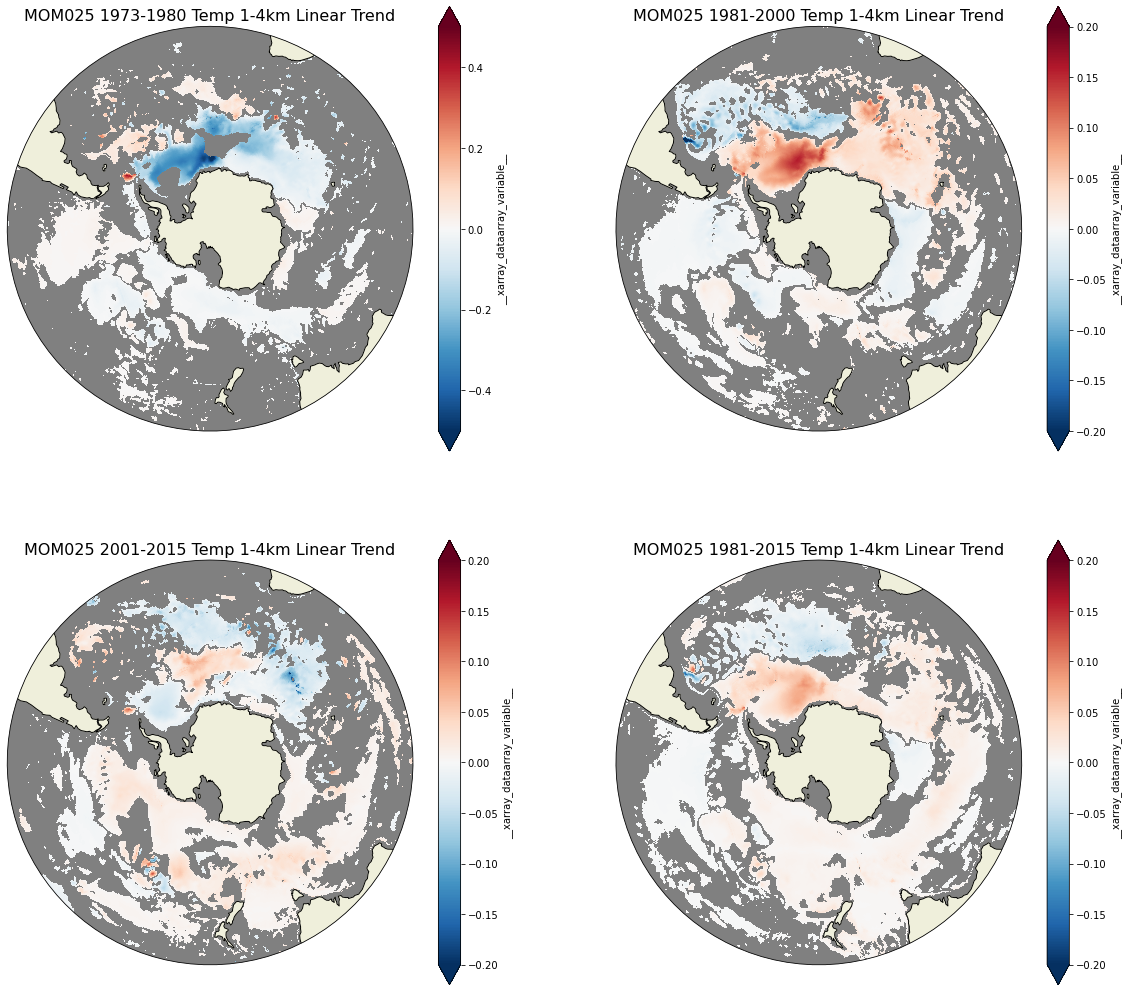

In [88]:
clev = np.arange(-.5,.55,.05)
clev = np.arange(-.2,.22,.02)

v1=-.5
v2=.5

fig = plt.figure(figsize=(20, 18))
    
projection=ccrs.SouthPolarStereo()

ax = plt.subplot(2,2,1, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([0, 360, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

m=xr.open_dataset('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr73to80_Tanom_1to4_m.nc').__xarray_dataarray_variable__*10
p=xr.open_dataset('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr73to80_Tanom_1to4_p.nc').__xarray_dataarray_variable__

p1 = m.where(p<=0.05).plot.pcolormesh(x='xt_ocean', y='yt_ocean', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p1 = trend_1970s_4km[0].where(trend_1970s_4km[0]!=0).plot.contourf(x='lon', y='lat', add_colorbar=True,cmap=cmocean.balance, levels=clev, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='MOM025 1973-1980 Temp 1-4km Linear Trend'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)


v1=-.2 #C/Decade *10 on load
v2=.2

ax = plt.subplot(2,2,2, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([0, 360, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

m=xr.open_dataset('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr81to00_Tanom_1to4_m.nc').__xarray_dataarray_variable__*10
p=xr.open_dataset('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr81to00_Tanom_1to4_p.nc').__xarray_dataarray_variable__

p1 = m.where(p<=0.05).plot.pcolormesh(x='xt_ocean', y='yt_ocean', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p1 = trend_1970s_4km[0].where(trend_1970s_4km[0]!=0).plot.contourf(x='lon', y='lat', add_colorbar=True,cmap=cmocean.balance, levels=clev, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='MOM025 1981-2000 Temp 1-4km Linear Trend'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)


ax = plt.subplot(2,2,3, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([0, 360, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

m=xr.open_dataset('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr01to15_Tanom_1to4_m.nc').__xarray_dataarray_variable__*10
p=xr.open_dataset('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr01to15_Tanom_1to4_p.nc').__xarray_dataarray_variable__

p1 = m.where(p<=0.05).plot.pcolormesh(x='xt_ocean', y='yt_ocean', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p1 = trend_1970s_4km[0].where(trend_1970s_4km[0]!=0).plot.contourf(x='lon', y='lat', add_colorbar=True,cmap=cmocean.balance, levels=clev, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='MOM025 2001-2015 Temp 1-4km Linear Trend'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)

ax = plt.subplot(2,2,4, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([0, 360, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

m=xr.open_dataset('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr81to15_Tanom_1to4_m.nc').__xarray_dataarray_variable__*10
p=xr.open_dataset('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr81to15_Tanom_1to4_p.nc').__xarray_dataarray_variable__

p1 = m.where(p<=0.05).plot.pcolormesh(x='xt_ocean', y='yt_ocean', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p1 = trend_1970s_4km[0].where(trend_1970s_4km[0]!=0).plot.contourf(x='lon', y='lat', add_colorbar=True,cmap=cmocean.balance, levels=clev, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='MOM025 1981-2015 Temp 1-4km Linear Trend'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)



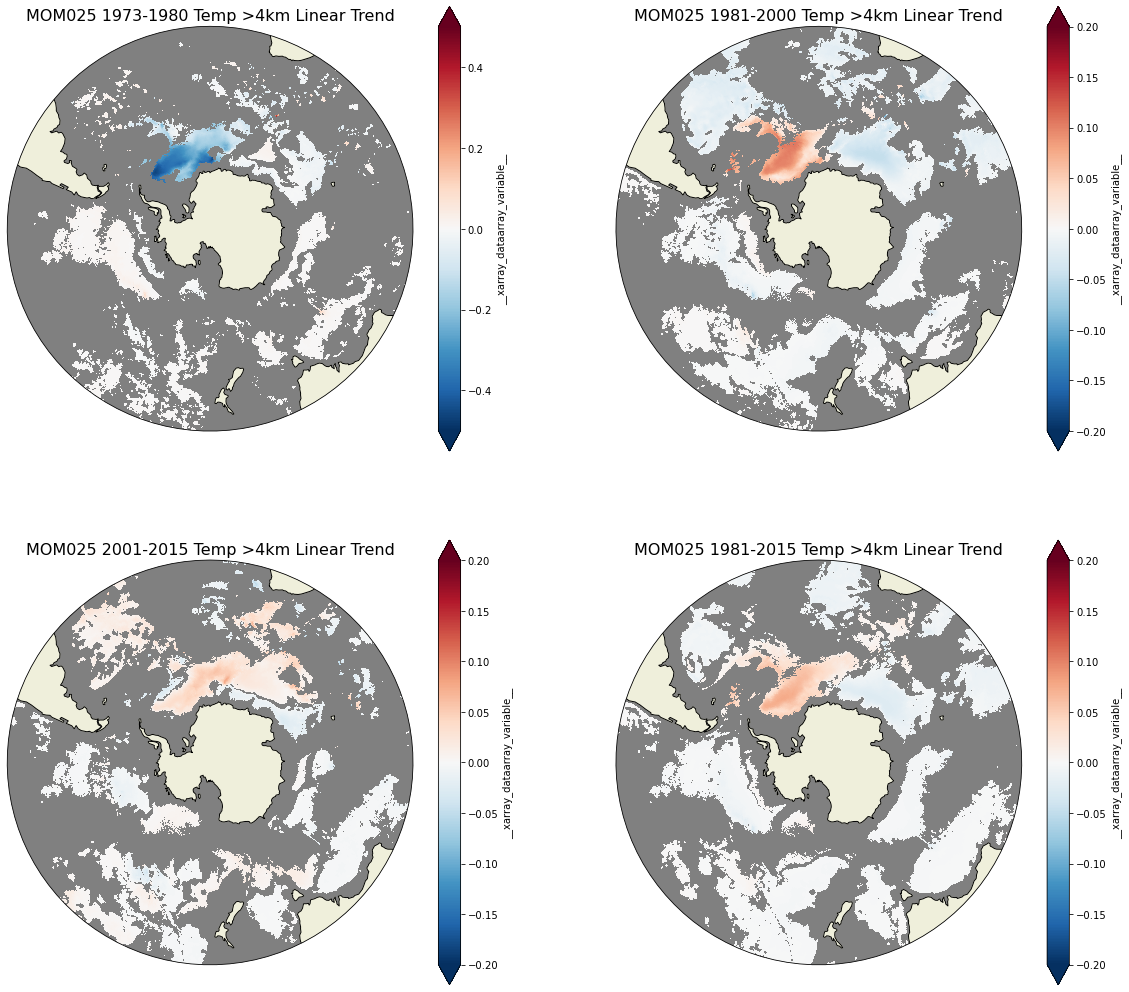

In [18]:
clev = np.arange(-.5,.55,.05)
clev = np.arange(-.2,.22,.02)

v1=-.5
v2=.5

fig = plt.figure(figsize=(20, 18))
    
projection=ccrs.SouthPolarStereo()

ax = plt.subplot(2,2,1, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([0, 360, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

m=xr.open_dataset('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr73to80_Tanom_4to6_m.nc').__xarray_dataarray_variable__*10
p=xr.open_dataset('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr73to80_Tanom_4to6_p.nc').__xarray_dataarray_variable__

p1 = m.where(p<=0.05).plot.pcolormesh(x='xt_ocean', y='yt_ocean', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p1 = trend_1970s_4km[0].where(trend_1970s_4km[0]!=0).plot.contourf(x='lon', y='lat', add_colorbar=True,cmap=cmocean.balance, levels=clev, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='MOM025 1973-1980 Temp >4km Linear Trend'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)


v1=-.2 #C/Decade *10 on load
v2=.2

ax = plt.subplot(2,2,2, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([0, 360, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

m=xr.open_dataset('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr81to00_Tanom_4to6_m.nc').__xarray_dataarray_variable__*10
p=xr.open_dataset('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr81to00_Tanom_4to6_p.nc').__xarray_dataarray_variable__

p1 = m.where(p<=0.05).plot.pcolormesh(x='xt_ocean', y='yt_ocean', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p1 = trend_1970s_4km[0].where(trend_1970s_4km[0]!=0).plot.contourf(x='lon', y='lat', add_colorbar=True,cmap=cmocean.balance, levels=clev, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='MOM025 1981-2000 Temp >4km Linear Trend'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)


ax = plt.subplot(2,2,3, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([0, 360, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

m=xr.open_dataset('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr01to15_Tanom_4to6_m.nc').__xarray_dataarray_variable__*10
p=xr.open_dataset('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr01to15_Tanom_4to6_p.nc').__xarray_dataarray_variable__

p1 = m.where(p<=0.05).plot.pcolormesh(x='xt_ocean', y='yt_ocean', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p1 = trend_1970s_4km[0].where(trend_1970s_4km[0]!=0).plot.contourf(x='lon', y='lat', add_colorbar=True,cmap=cmocean.balance, levels=clev, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='MOM025 2001-2015 Temp >4km Linear Trend'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)

ax = plt.subplot(2,2,4, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([0, 360, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

m=xr.open_dataset('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr81to15_Tanom_4to6_m.nc').__xarray_dataarray_variable__*10
p=xr.open_dataset('/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/np_tr81to15_Tanom_4to6_p.nc').__xarray_dataarray_variable__

p1 = m.where(p<=0.05).plot.pcolormesh(x='xt_ocean', y='yt_ocean', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p1 = trend_1970s_4km[0].where(trend_1970s_4km[0]!=0).plot.contourf(x='lon', y='lat', add_colorbar=True,cmap=cmocean.balance, levels=clev, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='MOM025 1981-2015 Temp >4km Linear Trend'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)



In [89]:
#Do MOM01 Now

In [5]:
NYFCntrlDir = '/g/data3/hh5/tmp/pas561/kds75_cp_ann/'
NYFPertDir = '/g/data/hh5/tmp/pas561/kds75_wp2/2yr/'

of1=os.path.join(NYFCntrlDir,'cT_0to1.npy')
of2=os.path.join(NYFCntrlDir,'cT_0to1_141to155.npy')

mom01_cT_0to1=np.concatenate((np.load(of1),np.load(of2)),axis=0)
print(mom01_cT_0to1.shape)

of1=os.path.join(NYFCntrlDir,'cT_1to4.npy')
of2=os.path.join(NYFCntrlDir,'cT_1to4_141to155.npy')
mom01_cT_1to4=np.concatenate((np.load(of1),np.load(of2)),axis=0)
print(mom01_cT_1to4.shape)

of1=os.path.join(NYFCntrlDir,'cT_4to6.npy')
of2=os.path.join(NYFCntrlDir,'cT_4to6_141to155.npy')
mom01_cT_4to6=np.concatenate((np.load(of1),np.load(of2)),axis=0)
print(mom01_cT_4to6.shape)

(42, 1351, 3600)
(42, 1351, 3600)
(42, 1351, 3600)


In [6]:
of1=os.path.join(NYFPertDir,'pT_0to1.npy')
of2=os.path.join(NYFPertDir,'pT_0to1_141to154.npy')

mom01_pT_0to1=np.concatenate((np.load(of1),np.load(of2)),axis=0)
print(mom01_pT_0to1.shape)

of1=os.path.join(NYFPertDir,'pT_1to4.npy')
of2=os.path.join(NYFPertDir,'pT_1to4_141to154.npy')
mom01_pT_1to4=np.concatenate((np.load(of1),np.load(of2)),axis=0)
print(mom01_pT_1to4.shape)

of1=os.path.join(NYFPertDir,'pT_4to6.npy')
of2=os.path.join(NYFPertDir,'pT_4to6_141to154.npy')
mom01_pT_4to6=np.concatenate((np.load(of1),np.load(of2)),axis=0)
print(mom01_pT_4to6.shape)

(43, 1351, 3600)
(43, 1351, 3600)
(43, 1351, 3600)


In [8]:
mom01_tr81to15_Tanom_0to1_m=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))
mom01_tr81to15_Tanom_0to1_p=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))

mom01_tr81to15_Tanom_1to4_m=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))
mom01_tr81to15_Tanom_1to4_p=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))

mom01_tr81to15_Tanom_4to6_m=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))
mom01_tr81to15_Tanom_4to6_p=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))

mom01_tr73to80_Tanom_0to1_m=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))
mom01_tr73to80_Tanom_0to1_p=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))

mom01_tr73to80_Tanom_1to4_m=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))
mom01_tr73to80_Tanom_1to4_p=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))

mom01_tr73to80_Tanom_4to6_m=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))
mom01_tr73to80_Tanom_4to6_p=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))

mom01_tr81to00_Tanom_0to1_m=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))
mom01_tr81to00_Tanom_0to1_p=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))

mom01_tr81to00_Tanom_1to4_m=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))
mom01_tr81to00_Tanom_1to4_p=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))

mom01_tr81to00_Tanom_4to6_m=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))
mom01_tr81to00_Tanom_4to6_p=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))

mom01_tr01to15_Tanom_0to1_m=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))
mom01_tr01to15_Tanom_0to1_p=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))

mom01_tr01to15_Tanom_1to4_m=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))
mom01_tr01to15_Tanom_1to4_p=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))

mom01_tr01to15_Tanom_4to6_m=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))
mom01_tr01to15_Tanom_4to6_p=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))

anom_0to1=mom01_pT_0to1[:42,:,:]-mom01_cT_0to1[:42,:,:]
anom_1to4=mom01_pT_1to4[:42,:,:]-mom01_cT_1to4[:42,:,:]
anom_4to6=mom01_pT_4to6[:42,:,:]-mom01_cT_4to6[:42,:,:]

for j in range(0,mom01_pT_1to4.shape[1]):
    #print(j)
    
    for i in range(0,mom01_pT_1to4.shape[2]):
        
        tmp=sp.stats.linregress(range(34), anom_0to1[8:42,j,i])
        mom01_tr81to15_Tanom_0to1_m[j,i]=tmp.slope
        mom01_tr81to15_Tanom_0to1_p[j,i]=tmp.pvalue

        tmp=sp.stats.linregress(range(34), anom_1to4[8:42,j,i])
        mom01_tr81to15_Tanom_1to4_m[j,i]=tmp.slope
        mom01_tr81to15_Tanom_1to4_p[j,i]=tmp.pvalue

        tmp=sp.stats.linregress(range(34), anom_4to6[8:42,j,i])
        mom01_tr81to15_Tanom_4to6_m[j,i]=tmp.slope
        mom01_tr81to15_Tanom_4to6_p[j,i]=tmp.pvalue

        
        tmp=sp.stats.linregress(range(8), anom_0to1[0:8,j,i])
        mom01_tr73to80_Tanom_0to1_m[j,i]=tmp.slope
        mom01_tr73to80_Tanom_0to1_p[j,i]=tmp.pvalue

        tmp=sp.stats.linregress(range(8), anom_1to4[0:8,j,i])
        mom01_tr73to80_Tanom_1to4_m[j,i]=tmp.slope
        mom01_tr73to80_Tanom_1to4_p[j,i]=tmp.pvalue

        tmp=sp.stats.linregress(range(8), anom_4to6[0:8,j,i])
        mom01_tr73to80_Tanom_4to6_m[j,i]=tmp.slope
        mom01_tr73to80_Tanom_4to6_p[j,i]=tmp.pvalue
        
        
        tmp=sp.stats.linregress(range(20), anom_0to1[8:28,j,i])
        mom01_tr81to00_Tanom_0to1_m[j,i]=tmp.slope
        mom01_tr81to00_Tanom_0to1_p[j,i]=tmp.pvalue

        tmp=sp.stats.linregress(range(20), anom_1to4[8:28,j,i])
        mom01_tr81to00_Tanom_1to4_m[j,i]=tmp.slope
        mom01_tr81to00_Tanom_1to4_p[j,i]=tmp.pvalue

        tmp=sp.stats.linregress(range(20), anom_4to6[8:28,j,i])
        mom01_tr81to00_Tanom_4to6_m[j,i]=tmp.slope
        mom01_tr81to00_Tanom_4to6_p[j,i]=tmp.pvalue

        
        tmp=sp.stats.linregress(range(14), anom_0to1[28:42,j,i])
        mom01_tr01to15_Tanom_0to1_m[j,i]=tmp.slope
        mom01_tr01to15_Tanom_0to1_p[j,i]=tmp.pvalue

        tmp=sp.stats.linregress(range(14), anom_1to4[28:42,j,i])
        mom01_tr01to15_Tanom_1to4_m[j,i]=tmp.slope
        mom01_tr01to15_Tanom_1to4_p[j,i]=tmp.pvalue

        tmp=sp.stats.linregress(range(14), anom_4to6[28:42,j,i])
        mom01_tr01to15_Tanom_4to6_m[j,i]=tmp.slope
        mom01_tr01to15_Tanom_4to6_p[j,i]=tmp.pvalue
        

In [9]:
NYFCntrlDir = '/g/data/hh5/tmp/pas561/kds75_cp_ann/'
NYFPertDir = '/g/data/hh5/tmp/pas561/kds75_wp2/2yr/'

vgrid_file ='/g/data/hh5/tmp/pas561/kds75_cp_ann/ocean_130.nc'
nc = Dataset(vgrid_file, mode='r') # file handle, open in read only mode
yt_ocean = nc.variables['yt_ocean'][0:1351]
xt_ocean = nc.variables['xt_ocean'][:]
#potrho = nc.variables['potrho'][:]
nc.close() # close the file
#print potrho.shape
#print yu_ocean.shape

In [10]:
#0-1km
tmp = xr.DataArray(mom01_tr81to15_Tanom_0to1_m, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr81to15_Tanom_0to1_m.nc')

tmp = xr.DataArray(mom01_tr81to15_Tanom_0to1_p, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr81to15_Tanom_0to1_p.nc')

#1-4km
tmp = xr.DataArray(mom01_tr81to15_Tanom_1to4_m, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr81to15_Tanom_1to4_m.nc')

tmp = xr.DataArray(mom01_tr81to15_Tanom_1to4_p, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr81to15_Tanom_1to4_p.nc')

#4-6km
tmp = xr.DataArray(mom01_tr81to15_Tanom_4to6_m, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr81to15_Tanom_4to6_m.nc')

tmp = xr.DataArray(mom01_tr81to15_Tanom_4to6_p, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr81to15_Tanom_4to6_p.nc')

In [11]:
#0-1km
tmp = xr.DataArray(mom01_tr73to80_Tanom_0to1_m, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr73to80_Tanom_0to1_m.nc')

tmp = xr.DataArray(mom01_tr73to80_Tanom_0to1_p, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr73to80_Tanom_0to1_p.nc')

#1-4km
tmp = xr.DataArray(mom01_tr73to80_Tanom_1to4_m, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr73to80_Tanom_1to4_m.nc')

tmp = xr.DataArray(mom01_tr73to80_Tanom_1to4_p, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr73to80_Tanom_1to4_p.nc')

#4-6km
tmp = xr.DataArray(mom01_tr73to80_Tanom_4to6_m, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr73to80_Tanom_4to6_m.nc')

tmp = xr.DataArray(mom01_tr73to80_Tanom_4to6_p, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr73to80_Tanom_4to6_p.nc')

In [12]:
#0-1km
tmp = xr.DataArray(mom01_tr81to00_Tanom_0to1_m, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr81to00_Tanom_0to1_m.nc')

tmp = xr.DataArray(mom01_tr81to00_Tanom_0to1_p, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr81to00_Tanom_0to1_p.nc')

#1-4km
tmp = xr.DataArray(mom01_tr81to00_Tanom_1to4_m, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr81to00_Tanom_1to4_m.nc')

tmp = xr.DataArray(mom01_tr81to00_Tanom_1to4_p, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr81to00_Tanom_1to4_p.nc')

#4-6km
tmp = xr.DataArray(mom01_tr81to00_Tanom_4to6_m, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr81to00_Tanom_4to6_m.nc')

tmp = xr.DataArray(mom01_tr81to00_Tanom_4to6_p, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr81to00_Tanom_4to6_p.nc')

In [13]:
#0-1km
tmp = xr.DataArray(mom01_tr01to15_Tanom_0to1_m, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr01to15_Tanom_0to1_m.nc')

tmp = xr.DataArray(mom01_tr01to15_Tanom_0to1_p, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr01to15_Tanom_0to1_p.nc')

#1-4km
tmp = xr.DataArray(mom01_tr01to15_Tanom_1to4_m, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr01to15_Tanom_1to4_m.nc')

tmp = xr.DataArray(mom01_tr01to15_Tanom_1to4_p, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr01to15_Tanom_1to4_p.nc')

#4-6km
tmp = xr.DataArray(mom01_tr01to15_Tanom_4to6_m, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr01to15_Tanom_4to6_m.nc')

tmp = xr.DataArray(mom01_tr01to15_Tanom_4to6_p, 
coords={'yt_ocean':yt_ocean ,'xt_ocean': xt_ocean}, 
dims=["yt_ocean", "xt_ocean"])
tmp.to_netcdf('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr01to15_Tanom_4to6_p.nc')

In [14]:
m=xr.open_dataset('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr73to80_Tanom_0to1_m.nc')
m.__xarray_dataarray_variable__

<xarray.DataArray '__xarray_dataarray_variable__' (yt_ocean: 1351,
                                                   xt_ocean: 3600)>
[4863600 values with dtype=float64]
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 10.29 10.39 10.49
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95

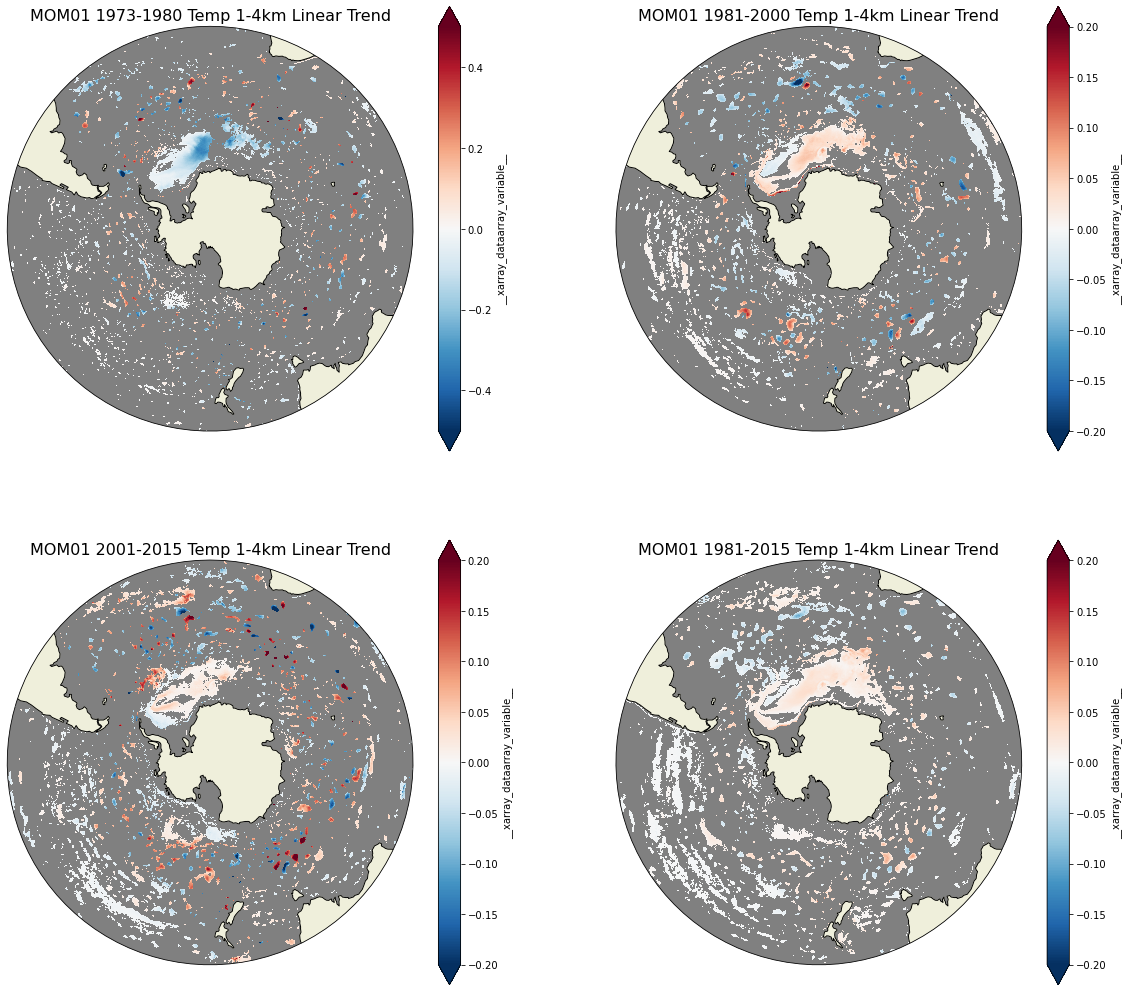

In [15]:
clev = np.arange(-.5,.55,.05)
clev = np.arange(-.2,.22,.02)

v1=-.5
v2=.5

fig = plt.figure(figsize=(20, 18))
    
projection=ccrs.SouthPolarStereo()

ax = plt.subplot(2,2,1, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([0, 360, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

m=xr.open_dataset('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr73to80_Tanom_1to4_m.nc').__xarray_dataarray_variable__*10
p=xr.open_dataset('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr73to80_Tanom_1to4_p.nc').__xarray_dataarray_variable__

p1 = m.where(p<=0.05).plot.pcolormesh(x='xt_ocean', y='yt_ocean', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p1 = trend_1970s_4km[0].where(trend_1970s_4km[0]!=0).plot.contourf(x='lon', y='lat', add_colorbar=True,cmap=cmocean.balance, levels=clev, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='MOM01 1973-1980 Temp 1-4km Linear Trend'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)


v1=-.2 #C/Decade *10 on load
v2=.2

ax = plt.subplot(2,2,2, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([0, 360, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

m=xr.open_dataset('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr81to00_Tanom_1to4_m.nc').__xarray_dataarray_variable__*10
p=xr.open_dataset('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr81to00_Tanom_1to4_p.nc').__xarray_dataarray_variable__

p1 = m.where(p<=0.05).plot.pcolormesh(x='xt_ocean', y='yt_ocean', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p1 = trend_1970s_4km[0].where(trend_1970s_4km[0]!=0).plot.contourf(x='lon', y='lat', add_colorbar=True,cmap=cmocean.balance, levels=clev, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='MOM01 1981-2000 Temp 1-4km Linear Trend'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)


ax = plt.subplot(2,2,3, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([0, 360, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

m=xr.open_dataset('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr01to15_Tanom_1to4_m.nc').__xarray_dataarray_variable__*10
p=xr.open_dataset('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr01to15_Tanom_1to4_p.nc').__xarray_dataarray_variable__

p1 = m.where(p<=0.05).plot.pcolormesh(x='xt_ocean', y='yt_ocean', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p1 = trend_1970s_4km[0].where(trend_1970s_4km[0]!=0).plot.contourf(x='lon', y='lat', add_colorbar=True,cmap=cmocean.balance, levels=clev, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='MOM01 2001-2015 Temp 1-4km Linear Trend'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)

ax = plt.subplot(2,2,4, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([0, 360, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

m=xr.open_dataset('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr81to15_Tanom_1to4_m.nc').__xarray_dataarray_variable__*10
p=xr.open_dataset('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr81to15_Tanom_1to4_p.nc').__xarray_dataarray_variable__

p1 = m.where(p<=0.05).plot.pcolormesh(x='xt_ocean', y='yt_ocean', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p1 = trend_1970s_4km[0].where(trend_1970s_4km[0]!=0).plot.contourf(x='lon', y='lat', add_colorbar=True,cmap=cmocean.balance, levels=clev, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='MOM01 1981-2015 Temp 1-4km Linear Trend'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)



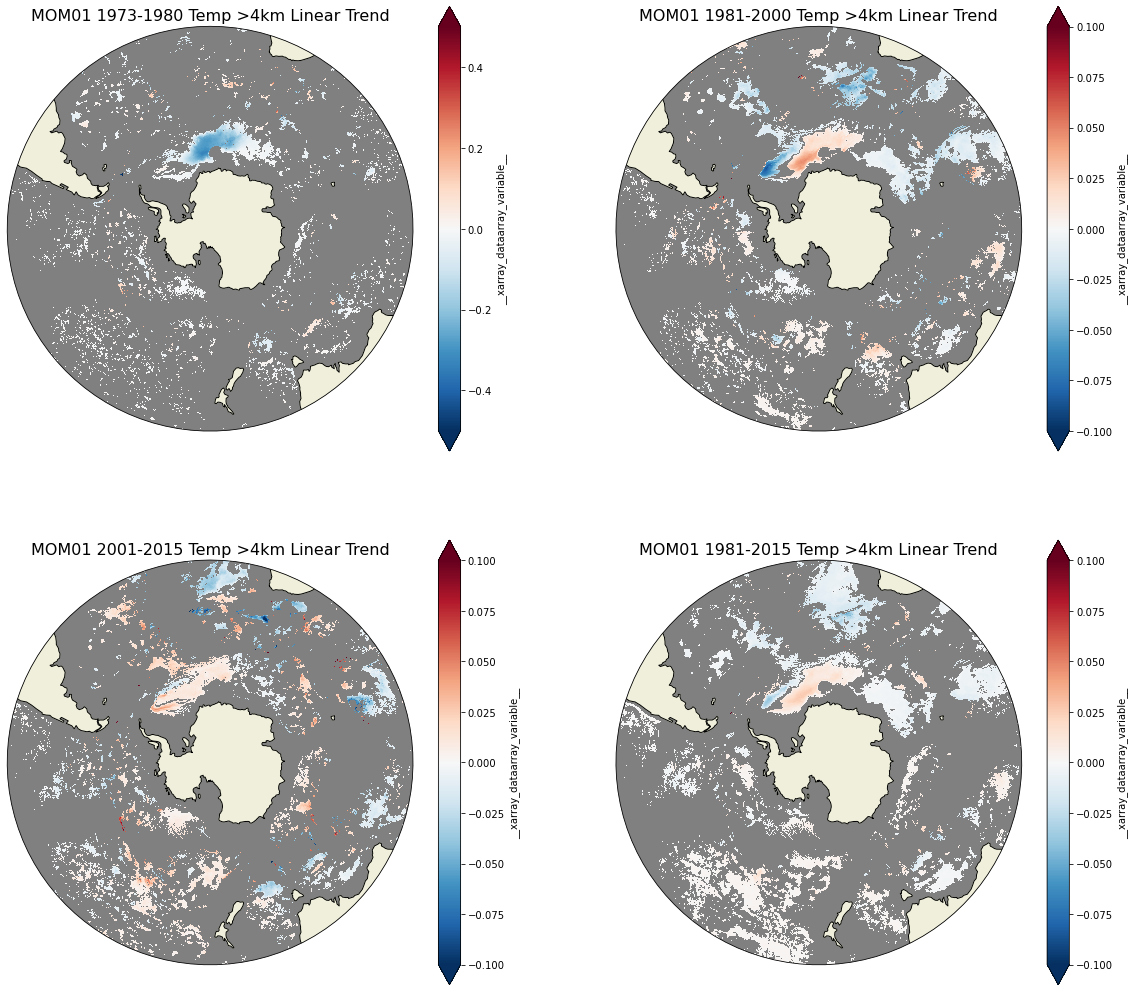

In [17]:
clev = np.arange(-.5,.55,.05)
clev = np.arange(-.2,.22,.02)

v1=-.5
v2=.5

fig = plt.figure(figsize=(20, 18))
    
projection=ccrs.SouthPolarStereo()

ax = plt.subplot(2,2,1, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([0, 360, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

m=xr.open_dataset('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr73to80_Tanom_4to6_m.nc').__xarray_dataarray_variable__*10
p=xr.open_dataset('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr73to80_Tanom_4to6_p.nc').__xarray_dataarray_variable__

p1 = m.where(p<=0.05).plot.pcolormesh(x='xt_ocean', y='yt_ocean', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p1 = trend_1970s_4km[0].where(trend_1970s_4km[0]!=0).plot.contourf(x='lon', y='lat', add_colorbar=True,cmap=cmocean.balance, levels=clev, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='MOM01 1973-1980 Temp >4km Linear Trend'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)


v1=-.1 #C/Decade *10 on load
v2=.1

ax = plt.subplot(2,2,2, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([0, 360, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

m=xr.open_dataset('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr81to00_Tanom_4to6_m.nc').__xarray_dataarray_variable__*10
p=xr.open_dataset('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr81to00_Tanom_4to6_p.nc').__xarray_dataarray_variable__

p1 = m.where(p<=0.05).plot.pcolormesh(x='xt_ocean', y='yt_ocean', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p1 = trend_1970s_4km[0].where(trend_1970s_4km[0]!=0).plot.contourf(x='lon', y='lat', add_colorbar=True,cmap=cmocean.balance, levels=clev, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='MOM01 1981-2000 Temp >4km Linear Trend'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)


ax = plt.subplot(2,2,3, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([0, 360, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

m=xr.open_dataset('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr01to15_Tanom_4to6_m.nc').__xarray_dataarray_variable__*10
p=xr.open_dataset('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr01to15_Tanom_4to6_p.nc').__xarray_dataarray_variable__

p1 = m.where(p<=0.05).plot.pcolormesh(x='xt_ocean', y='yt_ocean', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p1 = trend_1970s_4km[0].where(trend_1970s_4km[0]!=0).plot.contourf(x='lon', y='lat', add_colorbar=True,cmap=cmocean.balance, levels=clev, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='MOM01 2001-2015 Temp >4km Linear Trend'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)

ax = plt.subplot(2,2,4, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([0, 360, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

m=xr.open_dataset('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr81to15_Tanom_4to6_m.nc').__xarray_dataarray_variable__*10
p=xr.open_dataset('/g/data/hh5/tmp/pas561/kds75_wp2/2yr/mom01_tr81to15_Tanom_4to6_p.nc').__xarray_dataarray_variable__

p1 = m.where(p<=0.05).plot.pcolormesh(x='xt_ocean', y='yt_ocean', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p1 = trend_1970s_4km[0].where(trend_1970s_4km[0]!=0).plot.contourf(x='lon', y='lat', add_colorbar=True,cmap=cmocean.balance, levels=clev, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='MOM01 1981-2015 Temp >4km Linear Trend'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)



In [ ]:
#old poly fit method ... gets the trends but not the p-vals.

In [59]:
np_tr81to15_pT_1to4_p[200,200]

1.3253706086871295e-08

In [55]:
tmp.pvalue

1.3253706086871295e-08

In [38]:
tmp2

(array([[-0.0019639 , -0.00199281, -0.00201727, ..., -0.00191742,
         -0.00193295, -0.00194751],
        [ 0.15036768,  0.14668694,  0.14338712, ...,  0.15599114,
          0.15410029,  0.15244169]]),
 array([0.00119521, 0.00122461, 0.00125259, ..., 0.00116222, 0.00117132,
        0.00118144]),
 2,
 array([1.36371806, 0.37453043]),
 7.771561172376096e-15)

In [39]:
np_tr81to15_pT_1to4[j,200]

-0.001390250081441651

In [44]:
tmp3=np.asarray(tmp2)
tmp3

/jobfs/70146039.gadi-pbs/ipykernel_2511076/1808583220.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tmp3=np.asarray(tmp2)


array([array([[-0.0019639 , -0.00199281, -0.00201727, ..., -0.00191742,
               -0.00193295, -0.00194751],
              [ 0.15036768,  0.14668694,  0.14338712, ...,  0.15599114,
                0.15410029,  0.15244169]])                             ,
       array([0.00119521, 0.00122461, 0.00125259, ..., 0.00116222, 0.00117132,
              0.00118144])                                                    ,
       2, array([1.36371806, 0.37453043]), 7.771561172376096e-15],
      dtype=object)

In [51]:
tmp4=tmp3[1]
tmp4[200]

0.004065090353906961

In [132]:
print(np.sqrt(np.diag(cov[0,:])))

[0.00010072        nan]


/jobfs/70005543.gadi-pbs/ipykernel_2321619/2975746827.py:1: RuntimeWarning: invalid value encountered in sqrt
  print(np.sqrt(np.diag(cov[0,:])))


In [100]:
#calc dT/dt
cyrs=np.arange(1971,2017,1)
pyrs=np.arange(1973,2017,1)

#calc linear trend in C/s since 1981-2000 (8 years from 1973) 
#calc linear trend in C/s since 1981-2000 (8 years from 1973) 
print(cyrs[10:45],cyrs[10:45].shape)
print(pyrs[8:43],pyrs[8:43].shape)

print(cyrs[10:29],cyrs[10:29].shape)
print(pyrs[8:27],pyrs[8:27].shape)

print(cyrs[29:45],cyrs[29:45].shape)
print(pyrs[27:43],pyrs[27:43].shape)


np_tr81to99_pT_1to4=np.zeros((500,1440))
np_tr81to99_cT_1to4=np.zeros((500,1440))

np_tr81to99_pT_4to6=np.zeros((500,1440))
np_tr81to99_cT_4to6=np.zeros((500,1440))

np_tr00to15_pT_1to4=np.zeros((500,1440))
np_tr00to15_cT_1to4=np.zeros((500,1440))

np_tr00to15_pT_4to6=np.zeros((500,1440))
np_tr00to15_cT_4to6=np.zeros((500,1440))

np_tr81to15_pT_1to4=np.zeros((500,1440))
np_tr81to15_cT_1to4=np.zeros((500,1440))

np_tr81to15_pT_4to6=np.zeros((500,1440))
np_tr81to15_cT_4to6=np.zeros((500,1440))

for j in range(0,500):
    #print j
           
    #1-4km depg
    np_tr81to15_pT_1to4[j,:]=np.polyfit(range(35), np_pT_1to4[8:43,j,:],1,cov=True)[0,:]
    np_tr81to15_cT_1to4[j,:]=np.polyfit(range(35), np_cT_1to4[10:45,j,:],1)[0,:]

    np_tr81to99_pT_1to4[j,:]=np.polyfit(range(19), np_pT_1to4[8:27,j,:],1)[0,:]
    np_tr81to99_cT_1to4[j,:]=np.polyfit(range(19), np_cT_1to4[10:29,j,:],1)[0,:]

    np_tr00to15_pT_1to4[j,:]=np.polyfit(range(16), np_pT_1to4[27:43,j,:],1)[0,:]
    np_tr00to15_cT_1to4[j,:]=np.polyfit(range(16), np_cT_1to4[29:45,j,:],1)[0,:]

    
    #4-6km depg
    np_tr81to15_pT_4to6[j,:]=np.polyfit(range(35), np_pT_4to6[8:43,j,:],1)[0,:]
    np_tr81to15_cT_4to6[j,:]=np.polyfit(range(35), np_cT_4to6[10:45,j,:],1)[0,:]

    np_tr81to99_pT_4to6[j,:]=np.polyfit(range(19), np_pT_4to6[8:27,j,:],1)[0,:]
    np_tr81to99_cT_4to6[j,:]=np.polyfit(range(19), np_cT_4to6[10:29,j,:],1)[0,:]

    np_tr00to15_pT_4to6[j,:]=np.polyfit(range(16), np_pT_4to6[27:43,j,:],1)[0,:]
    np_tr00to15_cT_4to6[j,:]=np.polyfit(range(16), np_cT_4to6[29:45,j,:],1)[0,:]


[1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994
 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014 2015] (35,)
[1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994
 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014 2015] (35,)
[1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994
 1995 1996 1997 1998 1999] (19,)
[1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994
 1995 1996 1997 1998 1999] (19,)
[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015] (16,)
[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015] (16,)


In [101]:
vgrid_file ='/g/data/hh5/tmp/pas561/gfdl_nyf_1080/ocean.ncra501-520.nc'

nc = Dataset(vgrid_file, mode='r') # file handle, open in read only mode
yt_ocean = nc.variables['yt_ocean'][0:500]
xt_ocean = nc.variables['xt_ocean'][:]
nc.close() # close the file
#print st_ocean.shape
#print potrho.shape
#print yt_ocean.shape


In [102]:
np_tr81to15_cT_1to4_xr = xr.DataArray(np_tr81to15_cT_1to4, 
coords={'lat':yt_ocean ,'lon': xt_ocean}, 
dims=["lat", "lon"])

np_tr81to15_cT_4to6_xr = xr.DataArray(np_tr81to15_cT_4to6, 
coords={'lat':yt_ocean ,'lon': xt_ocean}, 
dims=["lat", "lon"])

np_tr81to15_pT_1to4_xr = xr.DataArray(np_tr81to15_pT_1to4, 
coords={'lat':yt_ocean ,'lon': xt_ocean}, 
dims=["lat", "lon"])

np_tr81to15_pT_4to6_xr = xr.DataArray(np_tr81to15_pT_4to6, 
coords={'lat':yt_ocean ,'lon': xt_ocean}, 
dims=["lat", "lon"])

In [103]:
np_tr81to99_cT_1to4_xr = xr.DataArray(np_tr81to99_cT_1to4, 
coords={'lat':yt_ocean ,'lon': xt_ocean}, 
dims=["lat", "lon"])

np_tr81to99_cT_4to6_xr = xr.DataArray(np_tr81to99_cT_4to6, 
coords={'lat':yt_ocean ,'lon': xt_ocean}, 
dims=["lat", "lon"])

np_tr81to99_pT_1to4_xr = xr.DataArray(np_tr81to99_pT_1to4, 
coords={'lat':yt_ocean ,'lon': xt_ocean}, 
dims=["lat", "lon"])

np_tr81to99_pT_4to6_xr = xr.DataArray(np_tr81to99_pT_4to6, 
coords={'lat':yt_ocean ,'lon': xt_ocean}, 
dims=["lat", "lon"])

In [104]:
np_tr00to15_cT_1to4_xr = xr.DataArray(np_tr00to15_cT_1to4, 
coords={'lat':yt_ocean ,'lon': xt_ocean}, 
dims=["lat", "lon"])

np_tr00to15_cT_4to6_xr = xr.DataArray(np_tr00to15_cT_4to6, 
coords={'lat':yt_ocean ,'lon': xt_ocean}, 
dims=["lat", "lon"])

np_tr00to15_pT_1to4_xr = xr.DataArray(np_tr00to15_pT_1to4, 
coords={'lat':yt_ocean ,'lon': xt_ocean}, 
dims=["lat", "lon"])

np_tr00to15_pT_4to6_xr = xr.DataArray(np_tr00to15_pT_4to6, 
coords={'lat':yt_ocean ,'lon': xt_ocean}, 
dims=["lat", "lon"])

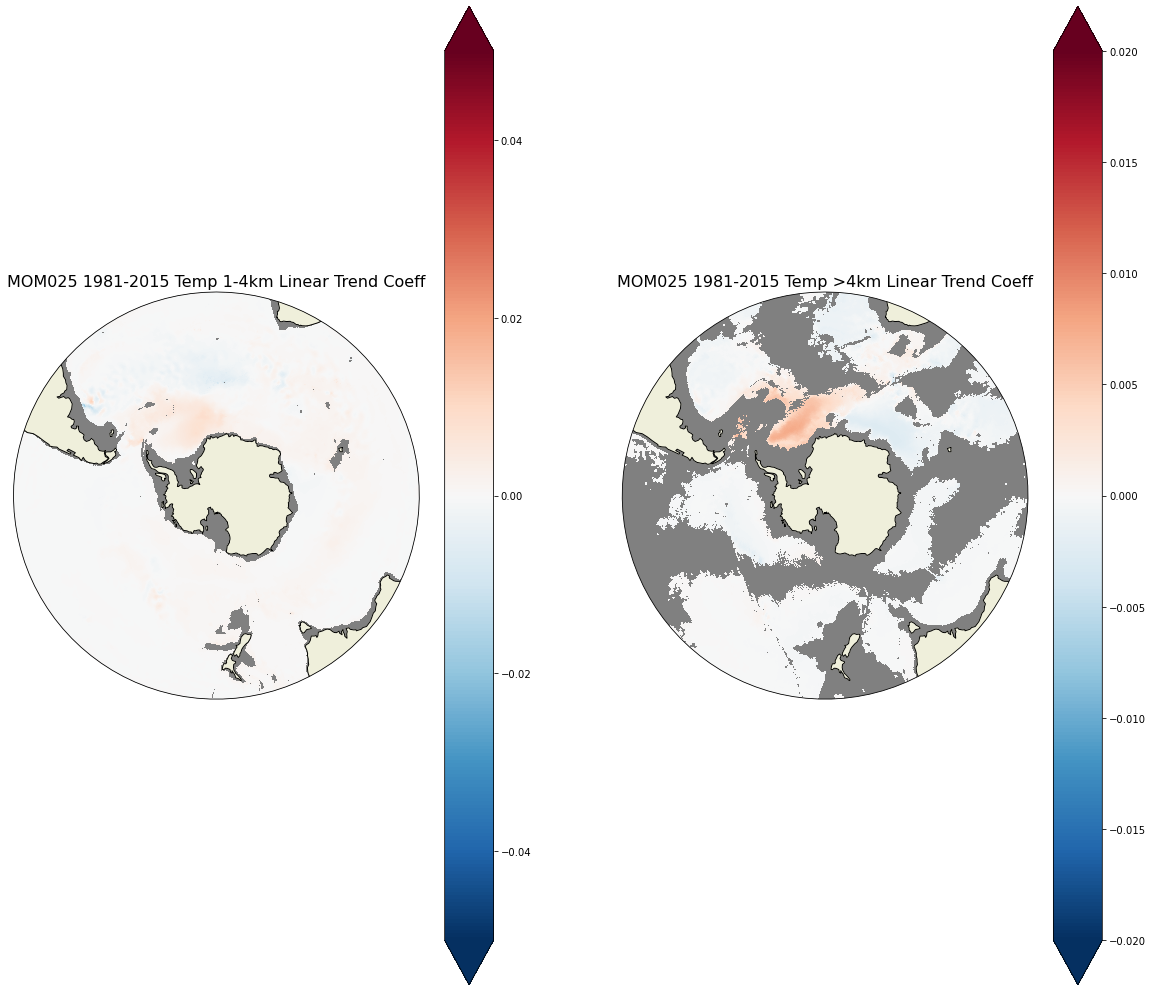

In [105]:
clev = np.arange(-.5,.55,.05)
clev = np.arange(-.2,.22,.02)


fig = plt.figure(figsize=(20, 18))
    
projection=ccrs.SouthPolarStereo()

ax = plt.subplot(1,2,1, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([-280, 80, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

v1=-.05
v2=.05

anom=np_tr81to15_pT_1to4_xr-np_tr81to15_cT_1to4_xr

p1 = anom.plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p1 = trend_1970s_4km[0].where(trend_1970s_4km[0]!=0).plot.contourf(x='lon', y='lat', add_colorbar=True,cmap=cmocean.balance, levels=clev, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='MOM025 1981-2015 Temp 1-4km Linear Trend Coeff'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)

ax = plt.subplot(1,2,2, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([-280, 80, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

v1=-.02
v2=.02
anom=np_tr81to15_pT_4to6_xr-np_tr81to15_cT_4to6_xr

#p1 = tmp.polyfit_coefficients[0].plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
p1 = anom.plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2,extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='MOM025 1981-2015 Temp >4km Linear Trend Coeff'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)


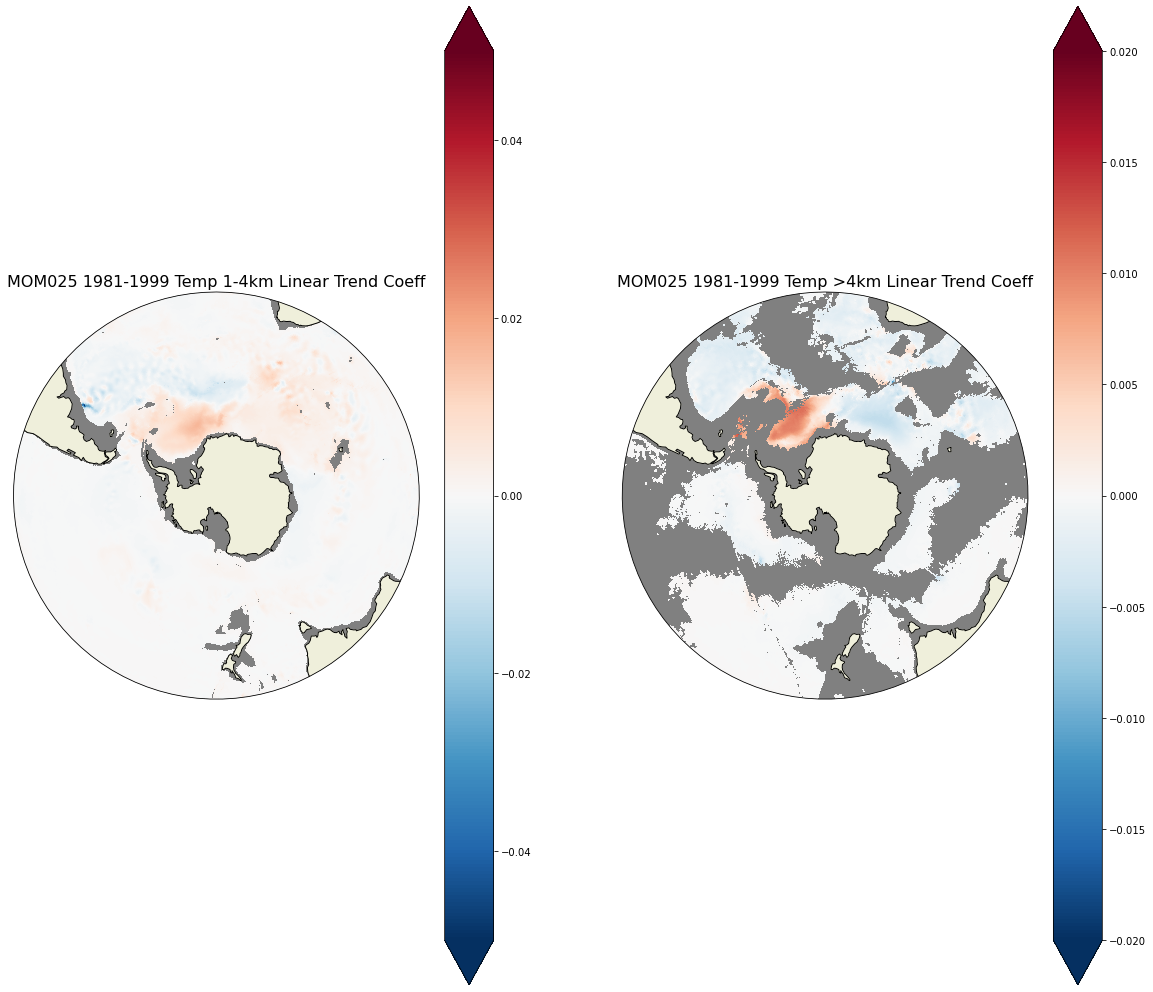

In [106]:
clev = np.arange(-.5,.55,.05)
clev = np.arange(-.2,.22,.02)


fig = plt.figure(figsize=(20, 18))
    
projection=ccrs.SouthPolarStereo()

ax = plt.subplot(1,2,1, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([-280, 80, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

v1=-.05
v2=.05

anom=np_tr81to99_pT_1to4_xr-np_tr81to99_cT_1to4_xr

p1 = anom.plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p1 = trend_1970s_4km[0].where(trend_1970s_4km[0]!=0).plot.contourf(x='lon', y='lat', add_colorbar=True,cmap=cmocean.balance, levels=clev, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='MOM025 1981-1999 Temp 1-4km Linear Trend Coeff'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)

ax = plt.subplot(1,2,2, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([-280, 80, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

v1=-.02
v2=.02
anom=np_tr81to99_pT_4to6_xr-np_tr81to99_cT_4to6_xr

#p1 = tmp.polyfit_coefficients[0].plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
p1 = anom.plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2,extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='MOM025 1981-1999 Temp >4km Linear Trend Coeff'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)


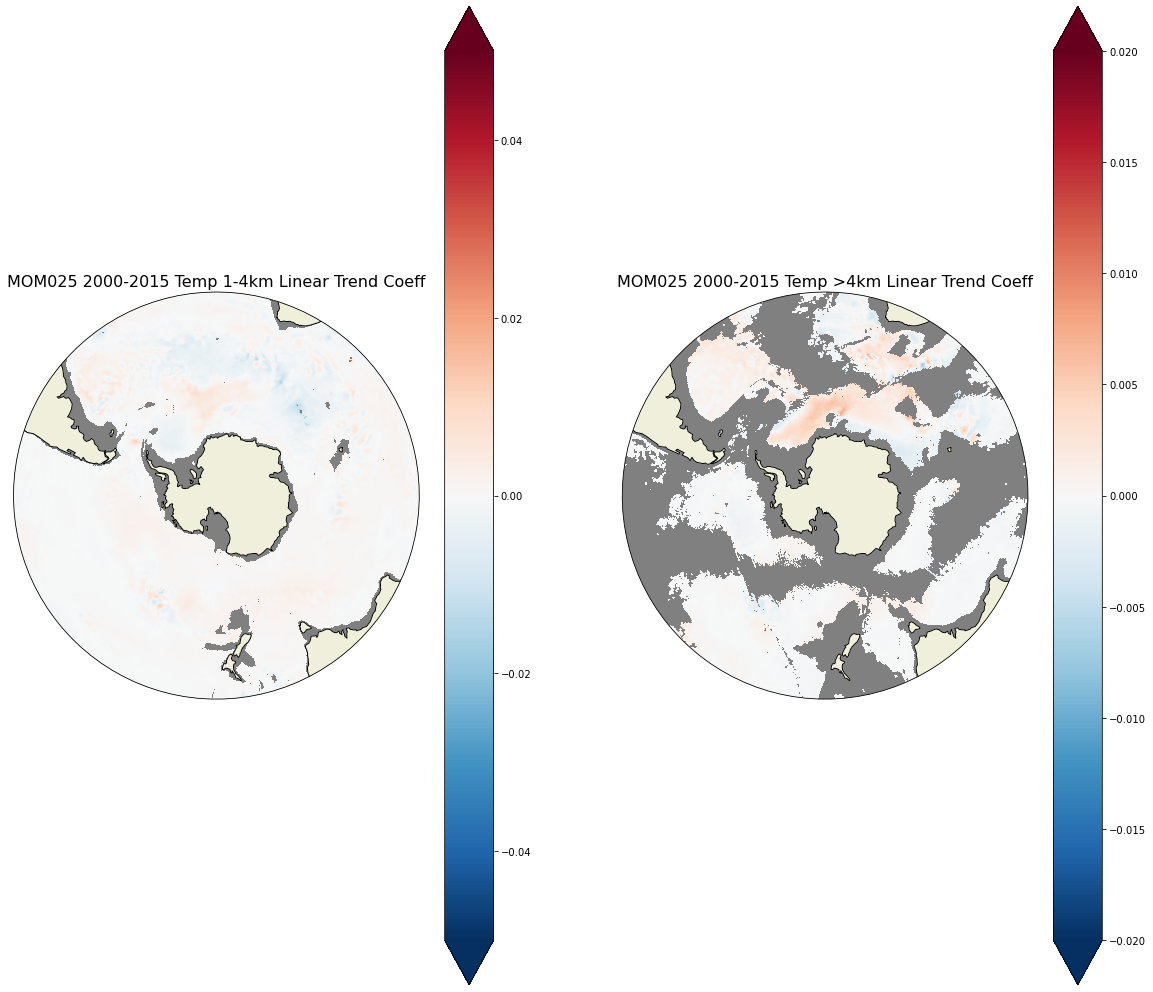

In [107]:
clev = np.arange(-.5,.55,.05)
clev = np.arange(-.2,.22,.02)


fig = plt.figure(figsize=(20, 18))
    
projection=ccrs.SouthPolarStereo()

ax = plt.subplot(1,2,1, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([-280, 80, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

v1=-.05
v2=.05

anom=np_tr00to15_pT_1to4_xr-np_tr00to15_cT_1to4_xr

p1 = anom.plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p1 = trend_1970s_4km[0].where(trend_1970s_4km[0]!=0).plot.contourf(x='lon', y='lat', add_colorbar=True,cmap=cmocean.balance, levels=clev, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='MOM025 2000-2015 Temp 1-4km Linear Trend Coeff'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)

ax = plt.subplot(1,2,2, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([-280, 80, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

v1=-.02
v2=.02
anom=np_tr00to15_pT_4to6_xr-np_tr00to15_cT_4to6_xr

#p1 = tmp.polyfit_coefficients[0].plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
p1 = anom.plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2,extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='MOM025 2000-2015 Temp >4km Linear Trend Coeff'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)


In [108]:
NYFCntrlDir = '/g/data3/hh5/tmp/pas561/kds75_cp_ann/'
NYFPertDir = '/g/data/hh5/tmp/pas561/kds75_wp2/2yr/'

of1=os.path.join(NYFCntrlDir,'cT_0to1.npy')
of2=os.path.join(NYFCntrlDir,'cT_0to1_141to155.npy')

mom01_cT_0to1=np.concatenate((np.load(of1),np.load(of2)),axis=0)
print(mom01_cT_0to1.shape)

of1=os.path.join(NYFCntrlDir,'cT_1to4.npy')
of2=os.path.join(NYFCntrlDir,'cT_1to4_141to155.npy')
mom01_cT_1to4=np.concatenate((np.load(of1),np.load(of2)),axis=0)
print(mom01_cT_1to4.shape)

of1=os.path.join(NYFCntrlDir,'cT_4to6.npy')
of2=os.path.join(NYFCntrlDir,'cT_4to6_141to155.npy')
mom01_cT_4to6=np.concatenate((np.load(of1),np.load(of2)),axis=0)
print(mom01_cT_4to6.shape)

(42, 1351, 3600)
(42, 1351, 3600)
(42, 1351, 3600)


In [109]:
of1=os.path.join(NYFPertDir,'pT_0to1.npy')
of2=os.path.join(NYFPertDir,'pT_0to1_141to154.npy')

mom01_pT_0to1=np.concatenate((np.load(of1),np.load(of2)),axis=0)
print(mom01_pT_0to1.shape)

of1=os.path.join(NYFPertDir,'pT_1to4.npy')
of2=os.path.join(NYFPertDir,'pT_1to4_141to154.npy')
mom01_pT_1to4=np.concatenate((np.load(of1),np.load(of2)),axis=0)
print(mom01_pT_1to4.shape)

of1=os.path.join(NYFPertDir,'pT_4to6.npy')
of2=os.path.join(NYFPertDir,'pT_4to6_141to154.npy')
mom01_pT_4to6=np.concatenate((np.load(of1),np.load(of2)),axis=0)
print(mom01_pT_4to6.shape)

(43, 1351, 3600)
(43, 1351, 3600)
(43, 1351, 3600)


In [111]:
pyrs=np.arange(1973,2017,1)

mom01_tr81to15_pT_1to4=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))
mom01_tr81to15_cT_1to4=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))

mom01_tr81to15_pT_4to6=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))
mom01_tr81to15_cT_4to6=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))

mom01_tr81to99_pT_1to4=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))
mom01_tr81to99_cT_1to4=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))

mom01_tr81to99_pT_4to6=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))
mom01_tr81to99_cT_4to6=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))

mom01_tr00to15_pT_1to4=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))
mom01_tr00to15_cT_1to4=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))

mom01_tr00to15_pT_4to6=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))
mom01_tr00to15_cT_4to6=np.zeros((mom01_pT_1to4.shape[1],mom01_pT_1to4.shape[2]))


print(mom01_tr81to15_cT_1to4.shape,mom01_tr81to15_pT_1to4.shape,mom01_cT_1to4[8:43,:,:].shape,mom01_pT_1to4[8:43,j,:].shape)

for j in range(0,mom01_pT_1to4.shape[1]):
    #print j
        
    
    mom01_tr81to15_cT_1to4[j,:]=np.polyfit(range(34), mom01_cT_1to4[8:42,j,:],1)[0,:]
    mom01_tr81to15_pT_1to4[j,:]=np.polyfit(range(35), mom01_pT_1to4[8:43,j,:],1)[0,:]

    #4-6km depg
    mom01_tr81to15_cT_4to6[j,:]=np.polyfit(range(34), mom01_cT_4to6[8:42,j,:],1)[0,:]
    mom01_tr81to15_pT_4to6[j,:]=np.polyfit(range(35), mom01_pT_4to6[8:43,j,:],1)[0,:]
    
    mom01_tr81to99_cT_1to4[j,:]=np.polyfit(range(19), mom01_cT_1to4[8:27,j,:],1)[0,:]
    mom01_tr81to99_pT_1to4[j,:]=np.polyfit(range(19), mom01_pT_1to4[8:27,j,:],1)[0,:]

    #4-6km depg
    mom01_tr81to99_cT_4to6[j,:]=np.polyfit(range(19), mom01_cT_4to6[8:27,j,:],1)[0,:]
    mom01_tr81to99_pT_4to6[j,:]=np.polyfit(range(19), mom01_pT_4to6[8:27,j,:],1)[0,:]
    
    mom01_tr00to15_cT_1to4[j,:]=np.polyfit(range(15), mom01_cT_1to4[27:42,j,:],1)[0,:]
    mom01_tr00to15_pT_1to4[j,:]=np.polyfit(range(16), mom01_pT_1to4[27:43,j,:],1)[0,:]

    #4-6km depg
    mom01_tr00to15_cT_4to6[j,:]=np.polyfit(range(15), mom01_cT_4to6[27:42,j,:],1)[0,:]
    mom01_tr00to15_pT_4to6[j,:]=np.polyfit(range(16), mom01_pT_4to6[27:43,j,:],1)[0,:]

(1351, 3600) (1351, 3600) (34, 1351, 3600) (35, 3600)


In [69]:
mom01_tr81to15_pT_4to6.shape

(1351, 3600)

In [71]:
#load gmoc in rho space
#NYFCntrlDir = '/g/data3/hh5/tmp/cosima/mom01v5/kds75_cp/'
#NYFPertDir = '/g/data3/hh5/tmp/pas561/kds75_wp2/2yr/'
NYFCntrlDir = '/g/data/hh5/tmp/pas561/kds75_cp_ann/'
NYFPertDir = '/g/data/hh5/tmp/pas561/kds75_wp2/2yr/'

#Ocean_File = os.path.join(NYFPertDir,'output*/ocean.nc')
#print Ocean_File
#pert=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
#print pert.ty_trans_rho.shape

vgrid_file ='/g/data/hh5/tmp/pas561/kds75_cp_ann/ocean_130.nc'
nc = Dataset(vgrid_file, mode='r') # file handle, open in read only mode
yt_ocean2 = nc.variables['yt_ocean'][0:1351]
xt_ocean2 = nc.variables['xt_ocean'][:]
#potrho = nc.variables['potrho'][:]
nc.close() # close the file
#print potrho.shape
#print yu_ocean.shape


In [112]:
mom01_tr81to15_cT_1to4_xr = xr.DataArray(mom01_tr81to15_cT_1to4, 
coords={'lat':yt_ocean2 ,'lon': xt_ocean2}, 
dims=["lat", "lon"])

mom01_tr81to15_cT_4to6_xr = xr.DataArray(mom01_tr81to15_cT_4to6, 
coords={'lat':yt_ocean2 ,'lon': xt_ocean2}, 
dims=["lat", "lon"])

mom01_tr81to15_pT_1to4_xr = xr.DataArray(mom01_tr81to15_pT_1to4, 
coords={'lat':yt_ocean2 ,'lon': xt_ocean2}, 
dims=["lat", "lon"])

mom01_tr81to15_pT_4to6_xr = xr.DataArray(mom01_tr81to15_pT_4to6, 
coords={'lat':yt_ocean2 ,'lon': xt_ocean2}, 
dims=["lat", "lon"])

#mom01_tr81to15_pT_4to6_xr.plot()

In [114]:
mom01_tr81to99_cT_1to4_xr = xr.DataArray(mom01_tr81to99_cT_1to4, 
coords={'lat':yt_ocean2 ,'lon': xt_ocean2}, 
dims=["lat", "lon"])

mom01_tr81to99_cT_4to6_xr = xr.DataArray(mom01_tr81to99_cT_4to6, 
coords={'lat':yt_ocean2 ,'lon': xt_ocean2}, 
dims=["lat", "lon"])

mom01_tr81to99_pT_1to4_xr = xr.DataArray(mom01_tr81to99_pT_1to4, 
coords={'lat':yt_ocean2 ,'lon': xt_ocean2}, 
dims=["lat", "lon"])

mom01_tr81to99_pT_4to6_xr = xr.DataArray(mom01_tr81to99_pT_4to6, 
coords={'lat':yt_ocean2 ,'lon': xt_ocean2}, 
dims=["lat", "lon"])

In [115]:
mom01_tr00to15_cT_1to4_xr = xr.DataArray(mom01_tr00to15_cT_1to4, 
coords={'lat':yt_ocean2 ,'lon': xt_ocean2}, 
dims=["lat", "lon"])

mom01_tr00to15_cT_4to6_xr = xr.DataArray(mom01_tr00to15_cT_4to6, 
coords={'lat':yt_ocean2 ,'lon': xt_ocean2}, 
dims=["lat", "lon"])

mom01_tr00to15_pT_1to4_xr = xr.DataArray(mom01_tr00to15_pT_1to4, 
coords={'lat':yt_ocean2 ,'lon': xt_ocean2}, 
dims=["lat", "lon"])

mom01_tr00to15_pT_4to6_xr = xr.DataArray(mom01_tr00to15_pT_4to6, 
coords={'lat':yt_ocean2 ,'lon': xt_ocean2}, 
dims=["lat", "lon"])


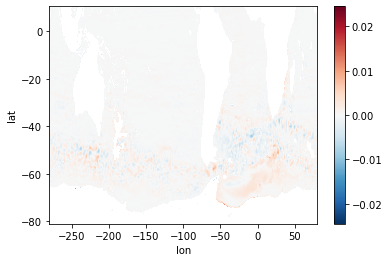

In [79]:
anom=mom01_tr81to15_pT_1to4_xr-mom01_tr81to15_cT_1to4_xr
anom.plot()

In [82]:
anom.lon

<xarray.DataArray 'lon' (lon: 3600)>
array([-279.95, -279.85, -279.75, ...,   79.75,   79.85,   79.95])
Coordinates:
  * lon      (lon) float64 -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95

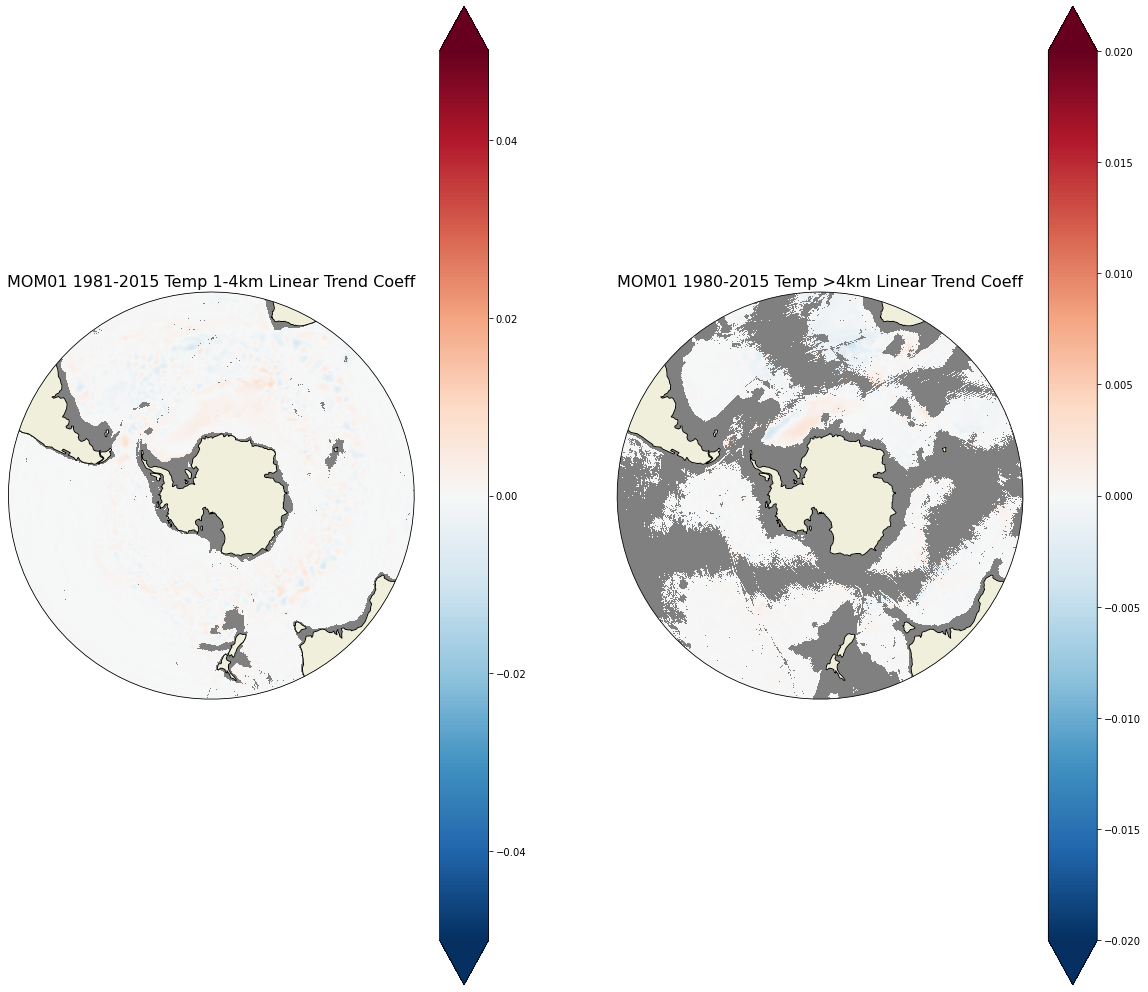

In [86]:
clev = np.arange(-.5,.55,.05)
clev = np.arange(-.2,.22,.02)


fig = plt.figure(figsize=(20, 18))
    
projection=ccrs.SouthPolarStereo()

ax = plt.subplot(1,2,1, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([-280, 80, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

v1=-.05
v2=.05

anom=mom01_tr81to15_pT_1to4_xr-mom01_tr81to15_cT_1to4_xr

p1 = anom.plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p1 = trend_1970s_4km[0].where(trend_1970s_4km[0]!=0).plot.contourf(x='lon', y='lat', add_colorbar=True,cmap=cmocean.balance, levels=clev, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='MOM01 1981-2015 Temp 1-4km Linear Trend Coeff'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)

ax = plt.subplot(1,2,2, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([-280, 80, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

v1=-.02
v2=.02
anom=mom01_tr81to15_pT_4to6_xr-mom01_tr81to15_cT_4to6_xr

#p1 = tmp.polyfit_coefficients[0].plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
p1 = anom.plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2,extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='MOM01 1980-2015 Temp >4km Linear Trend Coeff'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)


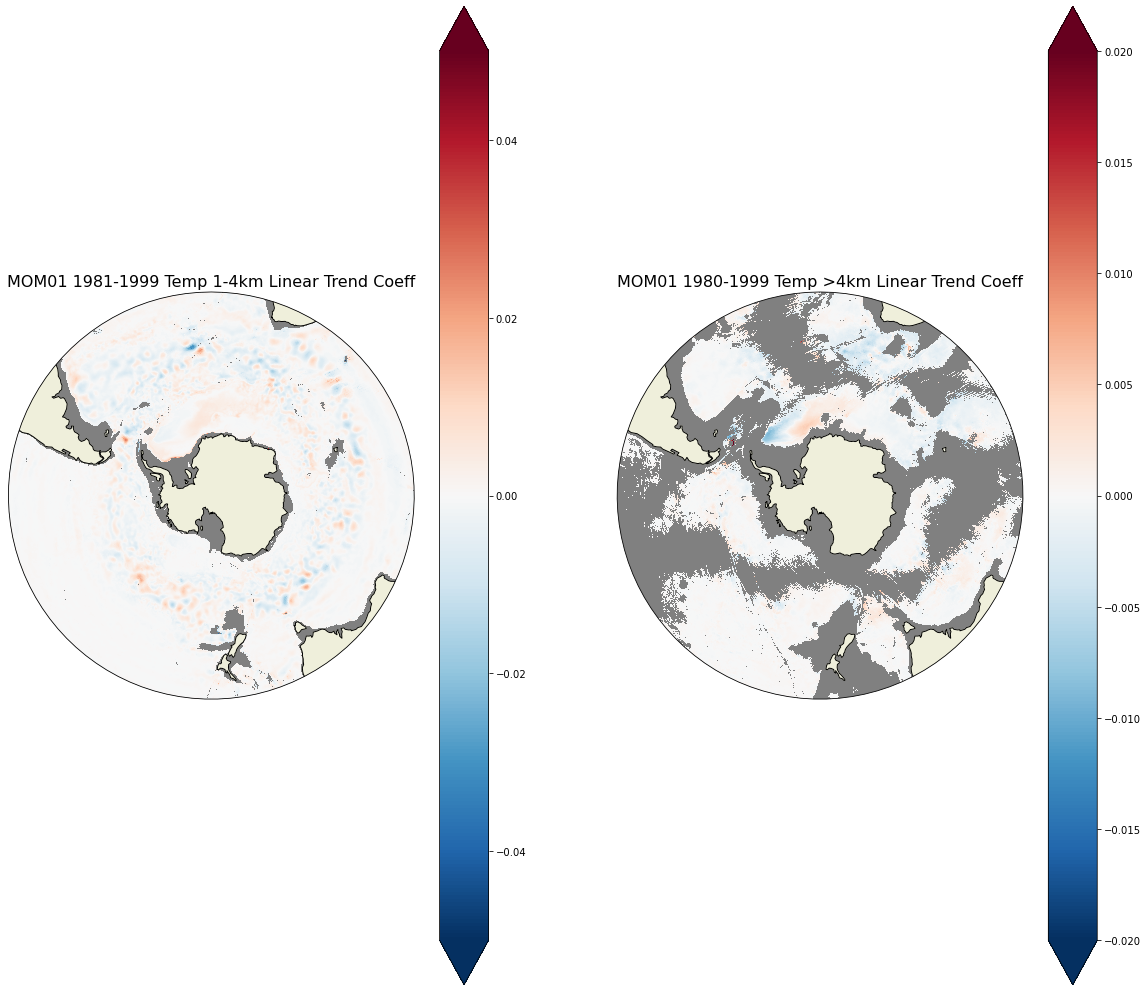

In [116]:
clev = np.arange(-.5,.55,.05)
clev = np.arange(-.2,.22,.02)


fig = plt.figure(figsize=(20, 18))
    
projection=ccrs.SouthPolarStereo()

ax = plt.subplot(1,2,1, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([-280, 80, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

v1=-.05
v2=.05

anom=mom01_tr81to99_pT_1to4_xr-mom01_tr81to99_cT_1to4_xr

p1 = anom.plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p1 = trend_1970s_4km[0].where(trend_1970s_4km[0]!=0).plot.contourf(x='lon', y='lat', add_colorbar=True,cmap=cmocean.balance, levels=clev, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='MOM01 1981-1999 Temp 1-4km Linear Trend Coeff'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)

ax = plt.subplot(1,2,2, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([-280, 80, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

v1=-.02
v2=.02
anom=mom01_tr81to99_pT_4to6_xr-mom01_tr81to99_cT_4to6_xr

#p1 = tmp.polyfit_coefficients[0].plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
p1 = anom.plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2,extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='MOM01 1980-1999 Temp >4km Linear Trend Coeff'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)


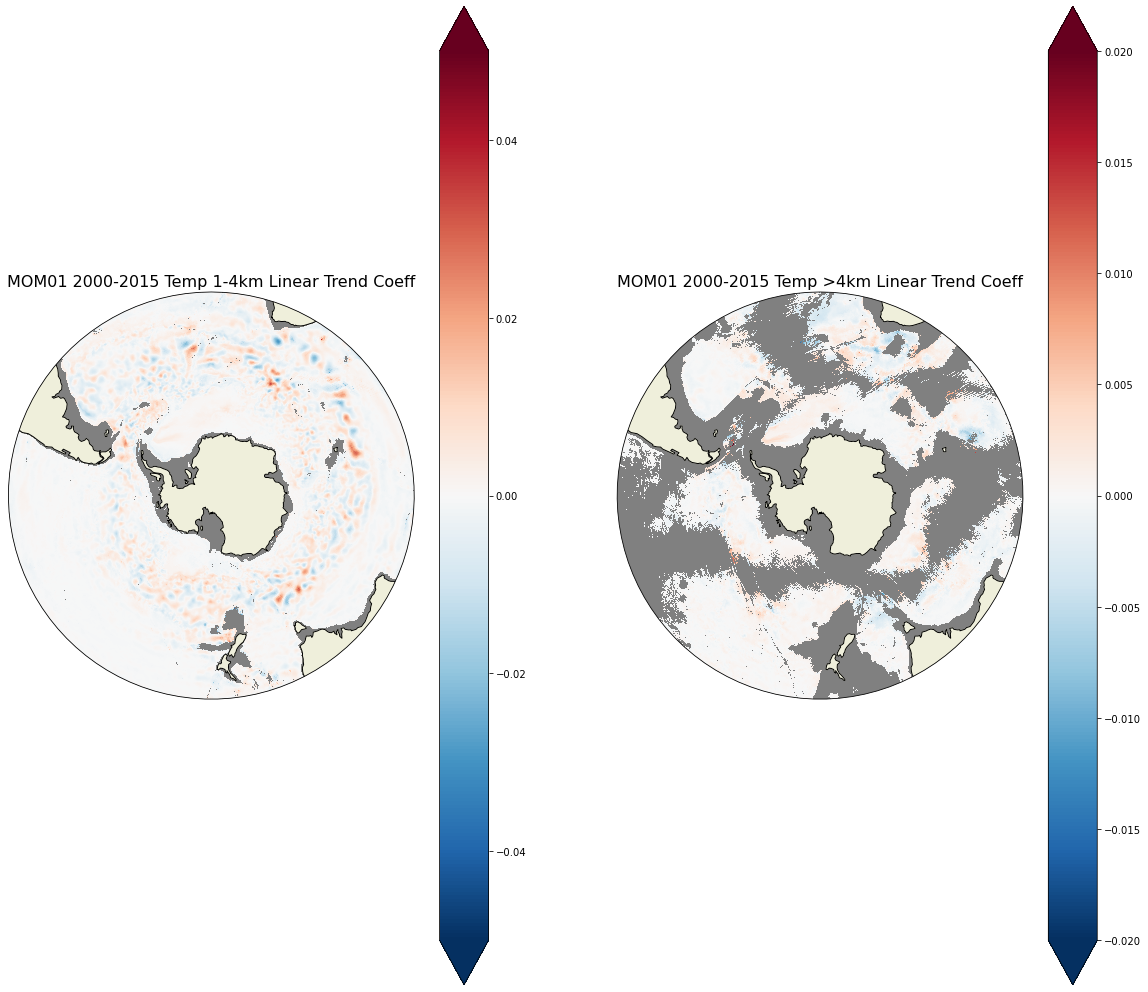

In [117]:
clev = np.arange(-.5,.55,.05)
clev = np.arange(-.2,.22,.02)


fig = plt.figure(figsize=(20, 18))
    
projection=ccrs.SouthPolarStereo()

ax = plt.subplot(1,2,1, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([-280, 80, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

v1=-.05
v2=.05

anom=mom01_tr00to15_pT_1to4_xr-mom01_tr00to15_cT_1to4_xr

p1 = anom.plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p1 = trend_1970s_4km[0].where(trend_1970s_4km[0]!=0).plot.contourf(x='lon', y='lat', add_colorbar=True,cmap=cmocean.balance, levels=clev, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='MOM01 2000-2015 Temp 1-4km Linear Trend Coeff'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)

ax = plt.subplot(1,2,2, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([-280, 80, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

v1=-.02
v2=.02
anom=mom01_tr00to15_pT_4to6_xr-mom01_tr00to15_cT_4to6_xr

#p1 = tmp.polyfit_coefficients[0].plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
p1 = anom.plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2,extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='MOM01 2000-2015 Temp >4km Linear Trend Coeff'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)


In [35]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap


In [ ]:
clev = np.arange(-.5,.55,.05)
clev = np.arange(-.2,.22,.02)


fig = plt.figure(figsize=(20, 18))
    
projection=ccrs.SouthPolarStereo()

ax = plt.subplot(1,2,1, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([0, 360, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

v1=-.05
v2=.05
p1 = trend_80to15_1km[0].where(trend_80to15_1km[0]!=0).plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p1 = trend_1970s_4km[0].where(trend_1970s_4km[0]!=0).plot.contourf(x='lon', y='lat', add_colorbar=True,cmap=cmocean.balance, levels=clev, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='1980-2015 Temp 1-4km Linear Trend Coeff'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)

ax = plt.subplot(1,2,2, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([0, 360, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

v1=-.02
v2=.02
#p1 = tmp.polyfit_coefficients[0].plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
p1 = trend_80to15_4km[0].where(trend_80to15_4km[0]!=0).plot.pcolormesh(x='lon', y='lat', add_colorbar=True,cmap=plt.cm.RdBu_r, vmin=v1, vmax=v2,extend='both', transform=ccrs.PlateCarree()) #vmin=-.05, vmax=.05
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='1980-2015 Temp >4km Linear Trend Coeff'
plt.title(tit,fontsize = 16)
ax.coastlines()
ax.add_feature(cfeature.LAND)


In [4]:
#compare depth integration to taimoor
#https://github.com/adele157/IAF-meltwater/issues/13#issuecomment-1247630055
anom=(en4.temperature.sel(time=slice('2009-01-01','2018-12-31')).mean(dim='time') - en4.temperature.sel(time=slice('1979-01-01','1998-12-31')).mean(dim='time')).compute()
anom

<xarray.DataArray 'temperature' (depth: 42, lat: 84, lon: 360)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.31887817, 0.24523926, 0.28396606, ..., 0.26950073,
         0.31851196, 0.3539734 ],
        [0.48114014, 0.35668945, 0.38482666, ..., 0.46765137,
         0.5107422 , 0.53692627],
        [0.50720215, 0.35403442, 0.37908936, ..., 0.5144043 ,
         0.5562439 , 0.57769775]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ..., 0.00918579,
         0.00839233,        nan],
        [       nan,        nan,        nan, ..., 0.0083313 ,
         0.00765991,        nan],
        [       nan,        nan,        nan, ..., 0.00738525,
         0.0067749 ,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * depth    (depth) float32 5.022 15.08 25.16 ... 4.752e+03 5.051e+03 5.35e+03
  * lat      (lat) float32 -83.0 -82.0 -81.0 -80.0 -79.0 ... -3.0 -2.0 -1.0 0.0
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0

In [8]:
en4_4km_v2=(anom.sel(depth=depth_slice)*en4_dzt_xr[37:]).sum(dim='depth')/ en4_dzt_xr[37:].values.sum()#. en4_km4_v2.depth
en4_4km_v2

<xarray.DataArray (lat: 84, lon: 360)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00301012, 0.00229731, 0.00214488, ..., 0.00630137, 0.00554523,
        0.00336344],
       [0.00398322, 0.00317314, 0.00300251, ..., 0.00727361, 0.00647496,
        0.00440354],
       [0.00482272, 0.00397013, 0.00286516, ..., 0.00800858, 0.00720397,
        0.00526732]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -83.0 -82.0 -81.0 -80.0 -79.0 ... -3.0 -2.0 -1.0 0.0
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0

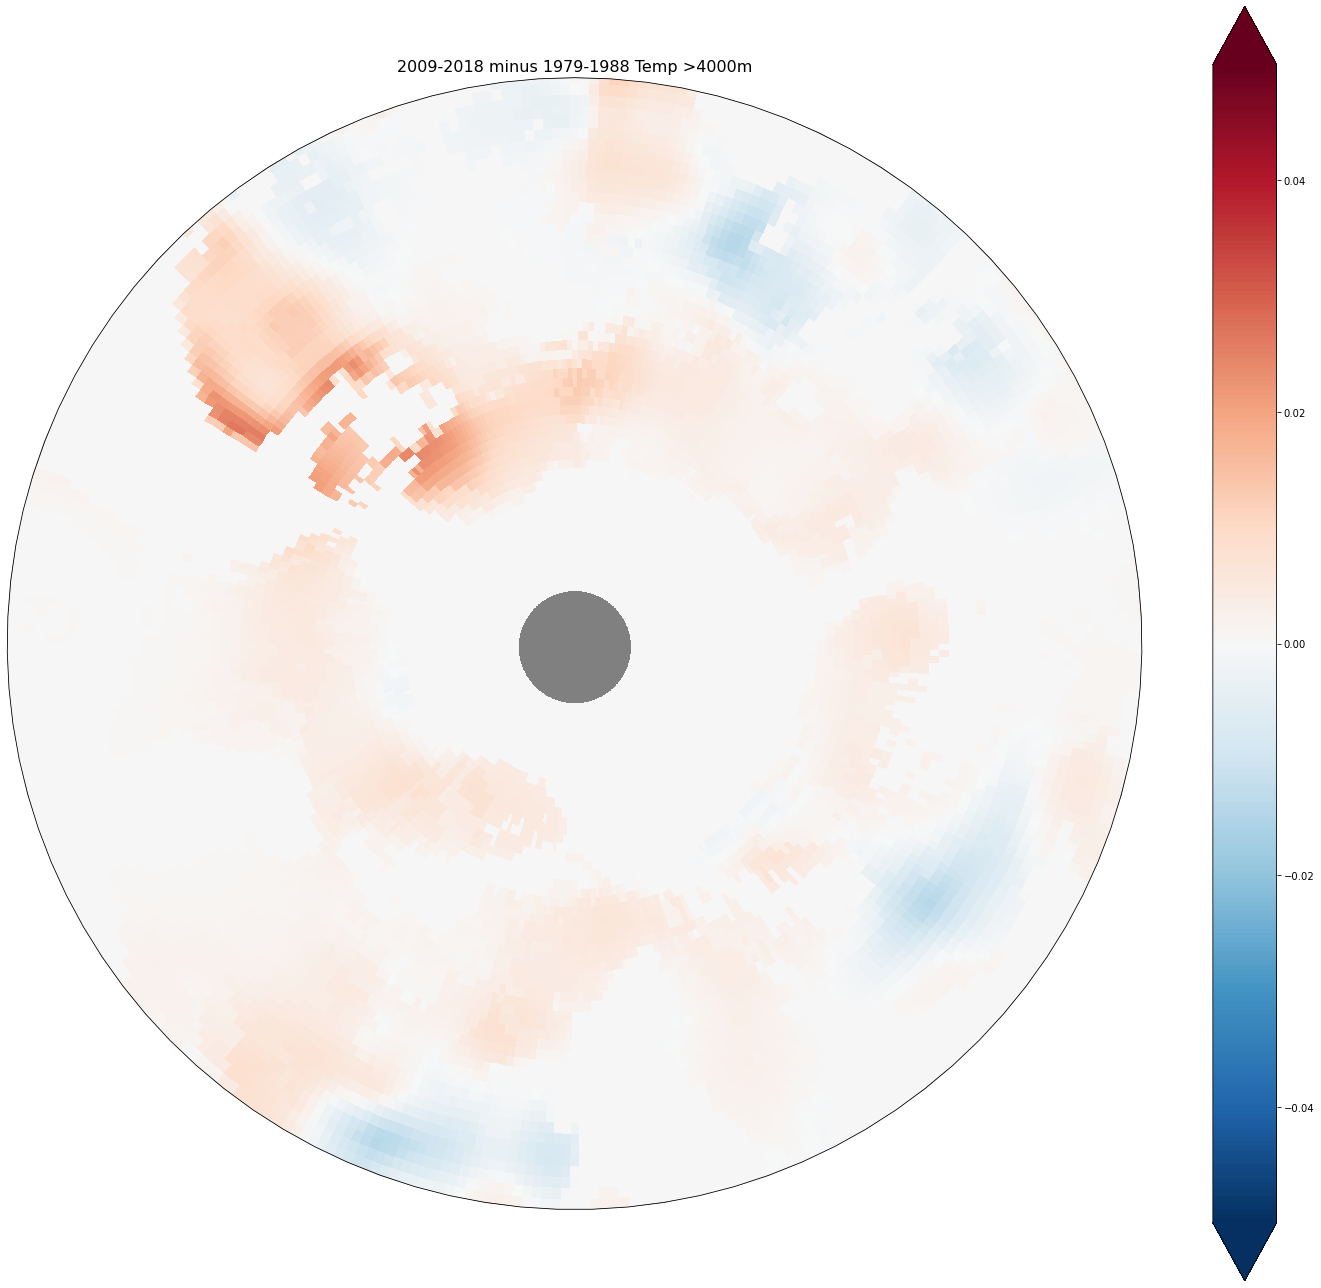

In [10]:
fig = plt.figure(figsize=(20, 18))
    
projection=ccrs.SouthPolarStereo()

ax = plt.subplot(1,1,1, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([0, 360, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

start_time='2009-01-01'
end_time='2018-12-31'

p1 = en4_4km_v2.plot.pcolormesh(x='lon', y='lat', add_colorbar=True, vmin=-.05, vmax=.05,cmap=plt.cm.RdBu_r, extend='both', transform=ccrs.PlateCarree())
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='2009-2018 minus 1979-1988 Temp >4000m'
plt.title(tit,fontsize = 16)

# colorbar:
##rect = [left, bottom, width, height]
#ax_cb = plt.axes([.95, 0.35, 0.015, 0.3])
#cb = plt.colorbar(p1,cax=ax_cb,orientation='vertical', extend='both', shrink=0.5)
#cb.ax.set_xlabel('m/day',fontsize=16);
#cb.ax.tick_params(labelsize=16) 
    
plt.tight_layout()

In [48]:
#is this correct? of do my own with dzt?
depth_slice=slice(4000,6000)
en4_4km=anom.sel(depth=depth_slice).weighted(en4_dzt_xr).mean(dim=('depth')).compute()
en4_4km

<xarray.DataArray 'temperature' (lat: 84, lon: 360)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.00502593, 0.00383576, 0.00358126, ..., 0.00788307, 0.00693713,
        0.00561585],
       [0.00665069, 0.00529812, 0.00501321, ..., 0.00909935, 0.00810024,
        0.00735249],
       [0.00805238, 0.00662883, 0.00718474, ..., 0.01001882, 0.00901223,
        0.00879471]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -83.0 -82.0 -81.0 -80.0 -79.0 ... -3.0 -2.0 -1.0 0.0
  * lon      (lon) float32 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0

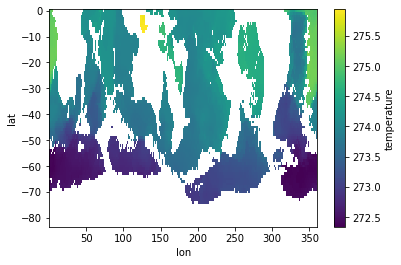

In [10]:
start_time='2009-01-01'
end_time='2018-12-31'
en4_4km.sel(time=slice(start_time,end_time)).mean(dim='time').plot()

Text(0.5, 1.0, '2009-2018 minus 179-1988 Temp >4000m')

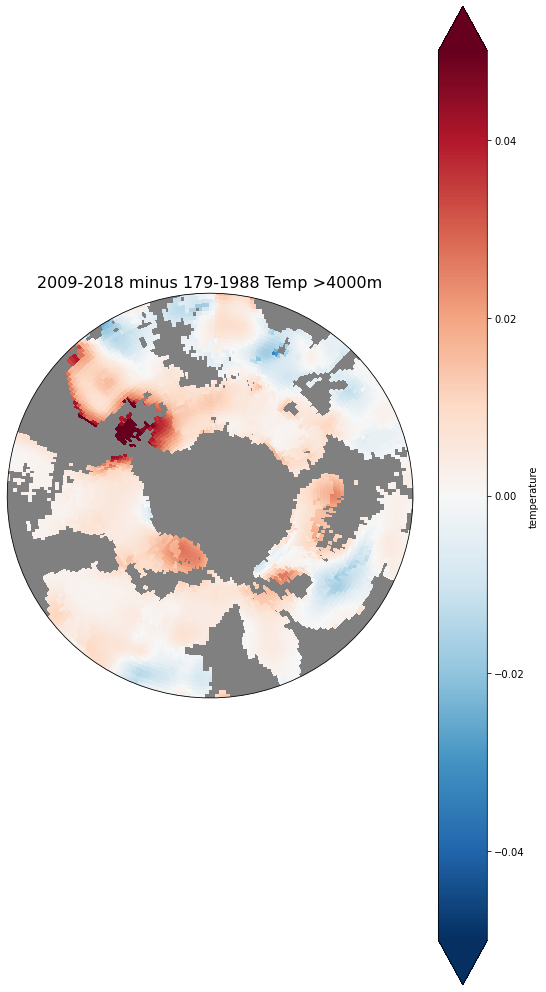

In [16]:
fig = plt.figure(figsize=(20, 18))
    
projection=ccrs.SouthPolarStereo()

ax = plt.subplot(1,2,1, projection=projection)
ax.patch.set_color('.5')

ax.set_extent([0, 360, -80, -30], crs=ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

start_time='2009-01-01'
end_time='2018-12-31'

p1 = (en4_4km.sel(time=slice('2009-01-01','2018-12-31')).mean(dim='time') - en4_4km.sel(time=slice('1979-01-01','1998-12-31')).mean(dim='time')).plot.pcolormesh(x='lon', y='lat', add_colorbar=True, vmin=-.05, vmax=.05,cmap=plt.cm.RdBu_r, extend='both', transform=ccrs.PlateCarree())
#p2 = en4.depth.plot.contour(ax=ax,
#                       x='lon', y='lat', levels=[1000], colors='k',linewidth=1,
#                       transform=ccrs.PlateCarree())

tit='2009-2018 minus 1979-1988 Temp >4000m'
plt.title(tit,fontsize = 16)

